<a href="https://colab.research.google.com/github/FFYICE/7150CEM-Data_Science_Project_YML/blob/main/TransformerNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [ ]:
#!pip install --target='/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages' pyautogui

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.2/61.2 kB 1.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 171.2/171.2 kB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 17.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 54.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyaut

In [ ]:
#!source /content/drive/MyDrive/virtual_env/bin/activate; pip install pymrmr

In [ ]:
!nvidia-smi

Sat Jul 20 10:53:30 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [1]:
import sys
# add the path of the virtual environmentsite-packages to colab system path
sys.path.append("/content/drive/MyDrive/virtual_env/lib/python3.10/site-packages")

In [2]:
import glob
import os
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import mne
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs
from mne_icalabel import label_components


import scipy.io
from scipy.stats import kurtosis
from scipy import signal

from tqdm import tqdm
#import pywt
#import pymrmr

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest,chi2,SelectPercentile
from sklearn.feature_selection import mutual_info_classif, f_classif
from sklearn.feature_selection import SelectFromModel
from sklearn.decomposition import PCA


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process.kernels import DotProduct
from sklearn.gaussian_process.kernels import Matern
from sklearn.gaussian_process.kernels import RationalQuadratic
from sklearn.gaussian_process.kernels import WhiteKernel


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score, auc
from sklearn.metrics import f1_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from keras import models
from keras import layers
from keras import optimizers
from tensorflow.keras import Model
from tensorflow.keras import layers
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import Hyperband
import keras_tuner as kt
from tensorflow.keras.layers import Conv3D, MaxPooling3D
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU
from scikeras.wrappers import KerasClassifier
from keras_tuner.tuners import GridSearch
from keras_tuner.engine.hyperparameters import HyperParameters
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

**Importing EEG matlab files to MNE raw object**

In [ ]:
# Defining basic parameter of EEG data
sfreq = 128.0
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2',
                 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']
montage = mne.channels.make_standard_montage('standard_1020')

In [ ]:
def process_mat_file(filepath):
    '''Function for uploading files'''
    mat = scipy.io.loadmat(filepath)
    base_name = os.path.splitext(os.path.basename(filepath))[0]

    # Extract the eeg data in folder using the base name as the key
    eeg_data = mat[base_name]

    if eeg_data.shape[1] < eeg_data.shape[0]:
        eeg_data = eeg_data.T

    montage = mne.channels.make_standard_montage('standard_1020')
    assert eeg_data.shape[0] == len(channel_names), "Mismatch between data channels and channel names."

    # Create MNE Info object
    info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')
    raw = mne.io.RawArray(eeg_data, info)

    # Apply montage(channel_location) to raw data
    raw.set_montage(montage)

    return base_name, raw

def process_directory(data_directory, raw_dict):
    '''Function to process all.mat files in a given directory and store into dictionary '''
    for filename in os.listdir(data_directory):
        if filename.endswith('.mat'):
            filepath = os.path.join(data_directory, filename)
            base_name, raw = process_mat_file(filepath)
            raw_dict[base_name] = raw

In [ ]:
raw_dict_ADHD = {}
raw_dict_Control = {}

ADHD_data_directory1 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET _1/ADHD_part1/ADHD_part1'
process_directory(ADHD_data_directory1, raw_dict_ADHD)

ADHD_data_directory2 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET _1/ADHD_part2/ADHD_part2'
process_directory(ADHD_data_directory2, raw_dict_ADHD)

Control_data_directory1 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET _1/Control_part1/Control_part1'
process_directory(Control_data_directory1, raw_dict_Control)

Control_data_directory2 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET _1/Control_part2/Control_part2'
process_directory(Control_data_directory2, raw_dict_Control)

**EEG preprocessing**\
Band pass filtering

In [ ]:
def band_pass_filters(raw_dict):
    ''' Function to apply filters to each Raw object in the dictionary'''
    for base_name, raw in raw_dict.items():
        raw.filter(l_freq = 4.0, h_freq = None) # High pass 4Hz
        raw.filter(l_freq = None, h_freq = 45.0) #Low pass 45Hz
        raw.notch_filter(freqs=50.0) # Notch filter at 50Hz for power line (Double check)

In [ ]:
band_pass_filters(raw_dict_ADHD)
band_pass_filters(raw_dict_Control)

**Systematic Artifacts Removal**\
Proposed method apply dual-criterion approach for analyse and identifying artifactual components in EEG data.
1.  ICA model is fitted based on infomax algorithm(𝑊=𝑊+𝑒𝑝𝑠∗∆𝑊)
  - eps is the learning rate.
  - ∆𝑊 is additive update
  - (Ille, 2023)
2.  Component classification by IC Label
  - 'eye blink,' 'muscle,' 'heart,' 'line noise,' 'channel noise,' 'other,' or 'brain'

3. Kurtosis Calculation
  -  High kurtosis values often indicate the presence of artifacts, particularly transient events like eye blinks(Jamil et al., 2021).
4. Adaptive Threshold (85 percentile)
 - Calculate Kurtosis threshold value of the current set of IC Label

5. Flag artifactual components
  - Components labeled as artifacts by IC Label is flagged
  - Components exceeding the adaptive kurtosis threshold are also flagged
  - Final set of artifactual components is determined by the intersection of these two criteria.
  - Exception apply to eyeblinks artifacts from IC Label to flag as artifacts even if kurtosis criteria is not satified by the components if eyeblinks label exceeded 65%

In [ ]:
def apply_ica_to_raw_dict(raw_dict, n_components=19, percentile=75, random_state=23, eye_blink_threshold=0.65):
    ''' Function for systematically removing artifacts based on two criteria'''
    ica_dict = {}
    bad_components_dict = {}
    labels_dict = {}

    for base_name, raw in tqdm(raw_dict.items()):
        print(f"Processing {base_name}...")

        # Run & fit ICA
        ica = ICA(n_components=n_components, random_state=random_state, method='infomax')
        ica.fit(raw)

        # ICLabel to classify components artifacts
        labels = label_components(raw, ica, method='iclabel')
        print(f"Component labels for {base_name}: {labels}")

        iclabel_bad_components = [
            idx for idx, (label, proba) in enumerate(zip(labels['labels'], labels['y_pred_proba']))
            if label in ['eye blink', 'muscle', 'heart', 'line noise', 'channel noise', 'other']
        ]
        print(f"ICLabel bad components for {base_name}: {iclabel_bad_components}")

        # Calculate kurtosis for each ICA component
        kurt_vals = kurtosis(ica.get_sources(raw).get_data(), axis=1)
        print(f"Kurtosis for {base_name}: {kurt_vals}")

        # Compute the adaptive threshold based on the percentile of kurtosis values
        adaptive_threshold = np.percentile(kurt_vals, percentile)
        print(f"Adaptive kurtosis threshold for {base_name} set at: {adaptive_threshold}")

        # Identify bad components based on adaptive threshold
        kurtosis_bad_components = np.where(kurt_vals > adaptive_threshold)[0]
        print(f"Initially flagged components for {base_name} based on kurtosis: {kurtosis_bad_components}")

         # Include components exceeding twice the adaptive threshold
        twice_threshold_bad_components = np.where(kurt_vals > 2 * adaptive_threshold)[0]
        print(f"Components exceeding twice the adaptive threshold for {base_name}: {twice_threshold_bad_components}")

        # Intersection of both criteria
        combined_bad_components = list(set(iclabel_bad_components) & set(kurtosis_bad_components))

        # Include eye blink components with probability > 65%
        final_bad_components = combined_bad_components + [
            idx for idx, (label, proba) in enumerate(zip(labels['labels'], labels['y_pred_proba']))
            if label == 'eye blink' and proba > eye_blink_threshold
        ]
        final_bad_components = list(set(final_bad_components + list(twice_threshold_bad_components)))

        print(f"Final bad components for {base_name}: {final_bad_components}")

        # Plot topography for flagged components
        #if len(final_bad_components) > 0:
            #ica.plot_properties(raw, picks=final_bad_components)

        labels_dict[base_name] = labels
        bad_components_dict[base_name] = final_bad_components

        ica.exclude = final_bad_components
        ica_dict[base_name] = ica

    return ica_dict, bad_components_dict, labels_dict


def process_raw_dict_set(raw_dict, ica_dict_name, bad_components_dict_name, labels_dict_name):
    '''Wrapper function to process different sets of raw_dict and store results in different dictionaries'''
    ica_dict, bad_components_dict, labels_dict = apply_ica_to_raw_dict(raw_dict)
    globals()[ica_dict_name] = ica_dict
    globals()[bad_components_dict_name] = bad_components_dict
    globals()[labels_dict_name] = labels_dict


In [ ]:
process_raw_dict_set(raw_dict_ADHD, 'ica_dict_ADHD', 'bad_components_dict_ADHD', 'labels_dict_ADHD')
process_raw_dict_set(raw_dict_Control, 'ica_dict_Control', 'bad_components_dict_Control', 'labels_dict_Control')

**Backproject ICA solution to EEG data**

In [ ]:
def apply_ica_solution_to_raw(raw_dict, ica_dict):
    ''' Function for backprojecting ICA solution to EEG data.
        Bad components are removed from each channels.'''
    raw_cleaned_dict = {}

    for base_name, raw in raw_dict.items():
        #print(f"Applying ICA solution to {base_name}...")
        raw_cleaned = raw.copy()

        ica = ica_dict[base_name]
        ica.apply(raw_cleaned)
        raw_cleaned_dict[base_name] = raw_cleaned

    return raw_cleaned_dict


def process_ica_solution(raw_dict, ica_dict, raw_cleaned_dict_name):
    '''Wrapper function to process different sets of raw_dict and store results in different dictionaries'''
    raw_cleaned_dict = apply_ica_solution_to_raw(raw_dict, ica_dict)
    globals()[raw_cleaned_dict_name] = raw_cleaned_dict


In [ ]:
process_ica_solution(raw_dict_ADHD, ica_dict_ADHD, 'raw_cleaned_dict_ADHD')
process_ica_solution(raw_dict_Control, ica_dict_Control, 'raw_cleaned_dict_Control')

In [ ]:
win = 4 * sf
freqs, psd = signal.welch(channel_data, sf, nperseg=win)

sns.set(font_scale=1.2, style='white')
plt.figure(figsize=(8, 4))
plt.plot(freqs, psd, color='k', lw=2)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power spectral density (V^2 / Hz)')
plt.ylim([0, psd.max() * 1.1])
plt.title("Welch's periodogram")
plt.xlim([0, freqs.max()])
plt.show()

**Convert Raw object to dataframe and save as CSV for feature extraction at matlab**

In [ ]:
def convert_and_save_raw_to_csv(raw_cleaned_dict, file_directory):
    """
    Convert MNE Raw objects to DataFrames and save each as a CSV file.

    Parameters:
    raw_cleaned_dict: Dictionary containing MNE Raw objects.
    file_directory: Directory where CSV files will be saved.
    """
    if not os.path.exists(file_directory):
        os.makedirs(file_directory, exist_ok=True)

    dataframes_dict = {}

    for key, raw in raw_cleaned_dict.items():
        data_ica = raw.get_data()
        df_ica = pd.DataFrame(data_ica.T, columns=raw.ch_names)
        dataframes_dict[key] = df_ica

        filename = f"{key}.csv"
        full_path = os.path.join(file_directory, filename)

        df_ica.to_csv(full_path, index=False)

    return dataframes_dict

In [ ]:
file_directory1 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET_2/ADHD_CSV'
file_directory2 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET_2/Control_CSV'

dict_df_ADHD = convert_and_save_raw_to_csv(raw_cleaned_dict_ADHD, file_directory1)
dict_df_Control = convert_and_save_raw_to_csv(raw_cleaned_dict_Control, file_directory2)

**Segmenting EEG data**\
4 second per segment with 1 second overlap

In [ ]:
def segment_eeg_data(dataframes_dict, segment_length_seconds=4, overlap_fraction=0.25, sampling_rate=128):
    segment_length_samples = int(segment_length_seconds * sampling_rate)
    overlap_samples = int(segment_length_samples * overlap_fraction)
    step_size = segment_length_samples - overlap_samples

    segmented_data_dict = {}

    for key, df in dataframes_dict.items():
        num_samples = len(df)
        segment_num = 0

        for start in range(0, num_samples - segment_length_samples + 1, step_size):
            end = start + segment_length_samples
            segment_df = df.iloc[start:end].reset_index(drop=True)
            segment_df = segment_df.apply(lambda x: x * np.hamming(len(x)))
            new_key = f"{key}_seg_{segment_num}"
            segmented_data_dict[new_key] = segment_df
            segment_num += 1

    return segmented_data_dict

def save_segmented_data(segmented_data_dict, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    for key, df in segmented_data_dict.items():
        file_path = os.path.join(output_folder, f"{key}.csv")
        df.to_csv(file_path, index=False)

In [ ]:
# Segment the data
segmented_dict_df_ADHD = segment_eeg_data(dict_df_ADHD)
segmented_dict_df_Control = segment_eeg_data(dict_df_Control)

file_directory1 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET_3/ADHD_CSV'
file_directory2 = 'C:/Users/Yuan/OneDrive - Coventry University/1.Class/1.Modules/7.7150CEM Final Report/ADHD/2.DATASET_3/Control_CSV'

save_segmented_data_1 = save_segmented_data(segmented_dict_df_ADHD, file_directory1)
save_segmented_data_2 = save_segmented_data(segmented_dict_df_Control, file_directory2)

In [3]:
def read_csvs_from_folder(folder_path):
    # Get all CSV files in the folder
    csv_files = glob.glob(os.path.join(folder_path, "*.csv"))

    # Dictionary to store DataFrames
    dataframes_dict = {}

    # Read each CSV file into a DataFrame
    for file in csv_files:
        df = pd.read_csv(file)
        file_name = os.path.basename(file).replace('.csv', '')
        dataframes_dict[file_name] = df

    return dataframes_dict

In [4]:
# Specify your directories
file_directory1 = '/content/drive/MyDrive/DATASET/ADHD/Segmented/ADHD_CSV'
file_directory2 = '/content/drive/MyDrive/DATASET/ADHD/Segmented/Control_CSV'

# Read CSV files from directories
dict_df_ADHD = read_csvs_from_folder(file_directory1)
dict_df_Control = read_csvs_from_folder(file_directory2)

In [ ]:
# Specify your directories
#file_directory1 = '/content/drive/MyDrive/DATASET/ADHD/ADHD'
#file_directory2 = '/content/drive/MyDrive/DATASET/ADHD/Control'

# Read CSV files from directories
#dict_df_ADHDxx = read_csvs_from_folder(file_directory1)
#dict_df_Controlxx = read_csvs_from_folder(file_directory2)

**RNN & Transformer Neural Network**

Padding data to ensure same length, same size

In [5]:
def prepare_patient_data(patient_data, segment_length, overlap_length, sampling_rate):
    """
    Prepare the dataset by applying padding to segment length less than 512 data point to single patient data.
    """
    valid_segments = []
    required_length = segment_length * sampling_rate
    min_valid_length = required_length // 2

    segment_samples = segment_length * sampling_rate
    overlap_samples = overlap_length * sampling_rate
    step = segment_samples - overlap_samples

    data = patient_data.values
    for start in range(0, len(data) - segment_samples + 1, step):
        segment = data[start:start + segment_samples]
        valid_segments.append(segment)

    # Handle the remaining data
    remaining_samples = len(data) % segment_samples
    if remaining_samples >= min_valid_length:
        remaining_data = data[-remaining_samples:]
        padding_value = np.mean(remaining_data, axis=0)
        padding = np.full((required_length - remaining_samples, remaining_data.shape[1]), padding_value)
        segment = np.vstack((remaining_data, padding))
        valid_segments.append(segment)

    return np.array(valid_segments)

def prepare_dataset(Control_dict, ADHD_dict, segment_length, overlap_length, sampling_rate):
    """
    Prepare the dataset by applying padding to segment length less than 512 data point to all patient data.

    """
    X_list = []
    y_list = []

    # Process data for non-ADHD (label 0)
    for patient_id, patient_data in Control_dict.items():
        X = prepare_patient_data(patient_data, segment_length, overlap_length, sampling_rate)
        y = np.zeros(len(X))
        X_list.extend(X)
        y_list.extend(y)

    # Process data for ADHD (label 1)
    for patient_id, patient_data in ADHD_dict.items():
        X = prepare_patient_data(patient_data, segment_length, overlap_length, sampling_rate)
        y = np.ones(len(X))
        X_list.extend(X)
        y_list.extend(y)

    # Convert lists to numpy arrays
    X_array = np.array(X_list)
    y_array = np.array(y_list)

    return X_array, y_array


In [6]:
segment_length = 4  # in seconds
overlap_length = 1  # in seconds (25% of 4 seconds)
sampling_rate = 128  # in Hz

In [7]:
X_NN, y_NN = prepare_dataset(dict_df_Control, dict_df_ADHD, segment_length, overlap_length, sampling_rate)

In [8]:
X_NN.shape

(5540, 512, 19)

**TNN Model Training & Testing**

In [9]:
X_train_NN, X_test_NN, y_train_NN, y_test_NN = train_test_split(X_NN, y_NN, test_size=0.20, random_state=19)

In [10]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads !=0:
             raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b = True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def seperate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm = [0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        query = self.seperate_heads(query, batch_size)
        key = self.seperate_heads(key, batch_size)
        value = self.seperate_heads(value, batch_size)

        attention, weights = self.attention(query, key, value)

        attention = tf.transpose(attention, perm=[0,2,1,3])

        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))

        output = self.combine_heads(concat_attention)

        return output

In [11]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation='relu'), layers.Dense(embed_dim)]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [12]:
def TNN_model():

    num_classes = 1
    activation_fn = 'sigmoid'

    inputs = layers.Input(shape=(512, 19))

    # Conv1D layer to initially process each channel
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    # Transformer Block
    transformer_block = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=32)
    transformer_block2 = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=32)
    x = transformer_block(x, training=True)
    x = transformer_block2(x, training=True)

    # Pooling layer to reduce dimensionality
    x = layers.GlobalAveragePooling1D()(x)

    # Dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Dense layer for classification
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation=activation_fn)(x)

    optimizer = Adam(clipvalue=0.5, learning_rate=0.001)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [14]:
TNNmodel = TNN_model()

In [18]:
TNN_history = TNNmodel.fit(X_train_NN, y_train_NN, epochs = 15, batch_size = 16, validation_split=0.2)

Epoch 1/20
222/222 [==============================] - 223s 904ms/step - loss: 0.4975 - accuracy: 0.7605 - val_loss: 0.3509 - val_accuracy: 0.8658
Epoch 2/20
222/222 [==============================] - 168s 758ms/step - loss: 0.3175 - accuracy: 0.8663 - val_loss: 0.2165 - val_accuracy: 0.9132
Epoch 3/20
222/222 [==============================] - 133s 600ms/step - loss: 0.2417 - accuracy: 0.9007 - val_loss: 0.1697 - val_accuracy: 0.9448
Epoch 4/20
222/222 [==============================] - 129s 582ms/step - loss: 0.1973 - accuracy: 0.9241 - val_loss: 0.1625 - val_accuracy: 0.9357
Epoch 5/20
222/222 [==============================] - 125s 565ms/step - loss: 0.1464 - accuracy: 0.9484 - val_loss: 0.1516 - val_accuracy: 0.9425
Epoch 6/20
222/222 [==============================] - 127s 571ms/step - loss: 0.1403 - accuracy: 0.9467 - val_loss: 0.1696 - val_accuracy: 0.9346
Epoch 7/20
222/222 [==============================] - 133s 602ms/step - loss: 0.1164 - accuracy: 0.9563 - val_loss: 0.1299 -

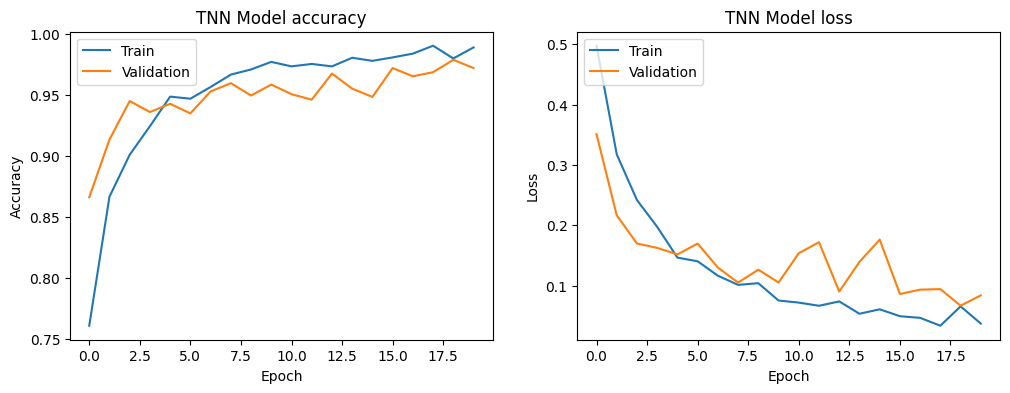

In [19]:
# Plot the training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('TNN Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('TNN Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(TNN_history)

In [21]:
# Evaluate the model
test_loss_tnn, test_accuracy_tnn = TNNmodel.evaluate(X_test_NN, y_test_NN)
print(f'TNN Test Accuracy: {test_accuracy_tnn:.4f}')

35/35 [==============================] - 33s 935ms/step - loss: 0.0819 - accuracy: 0.9720
TNN Test Accuracy: 0.9720


In [ ]:
# Evaluate the model
test_loss_tnn, test_accuracy_tnn = TNNmodel.evaluate(X_test_NN, y_test_NN)
print(f'TNN Test Accuracy: {test_accuracy_tnn:.4f}')

35/35 [==============================] - 11s 324ms/step - loss: 0.0494 - accuracy: 0.9838
TNN Test Accuracy: 0.9838


35/35 [==============================] - 15s 407ms/step


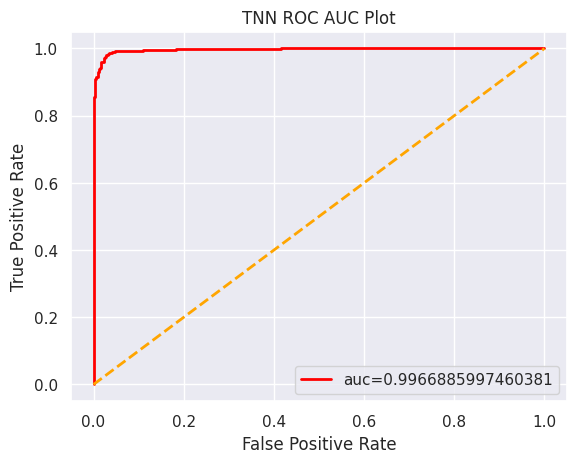

In [59]:
TNN_y_pred = TNNmodel.predict(X_test_NN)
TNN_fpr, TNN_tpr, _ = roc_curve(y_test_NN,  TNN_y_pred)
TNN_auc = roc_auc_score(y_test_NN, TNN_y_pred)
plt.plot(TNN_fpr,TNN_tpr,label="auc="+str(TNN_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

**CV-TNN**

In [ ]:
# Define number of splits
n_splits = 5
kf = KFold(n_splits=n_splits, shuffle=True, random_state=19)

# Store results for each fold
train_accuracies = []
val_accuracies = []

# Cross-validation loop
for train_index, val_index in kf.split(X_train_NN):
    X_train_fold, X_val_fold = X_train_NN[train_index], X_train_NN[val_index]
    y_train_fold, y_val_fold = y_train_NN[train_index], y_train_NN[val_index]

    history = TNNmodel.fit(X_train_fold, y_train_fold, epochs=20, batch_size=16, validation_data=(X_val_fold, y_val_fold), verbose=0)

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

# Average accuracy across folds
average_train_acc = np.mean(train_accuracies)
average_val_acc = np.mean(val_accuracies)

print(f'Average Training Accuracy: {average_train_acc:.4f}')
print(f'Average Validation Accuracy: {average_val_acc:.4f}')

Average Training Accuracy: 0.9910
Average Validation Accuracy: 0.9874


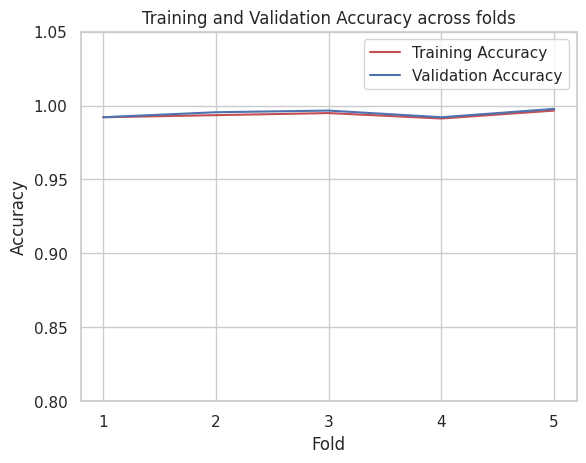

In [ ]:
# Plot training and validation accuracy for each fold
epochs = range(1, n_splits + 1)

plt.plot(epochs, train_accuracies, 'r', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy across folds')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.xticks([1, 2, 3, 4, 5])
plt.ylim(0.8, 1.05)
plt.legend()
plt.show()


**RNN** Initial Model

In [23]:
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = X_train_NN.copy(), X_test_NN.copy(), y_train_NN.copy(), y_test_NN.copy()

In [24]:
def RNN_model(X, dropout_rate=0.2, output_units=1, output_activation='sigmoid', learning_rate=0.001, clipvalue=0.5, loss='binary_crossentropy'):
    input_shape = (X.shape[1], X.shape[2])

    # Define the Adam optimizer with the specified learning rate and clipvalue
    optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)

    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_units, activation=output_activation))

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    return model

In [25]:
RNNmodel = RNN_model(X_train_RNN)
RNNmodel.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 512, 50)           3500      
                                                                 
 dropout_5 (Dropout)         (None, 512, 50)           0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 50)                5050      
                                                                 
 dropout_6 (Dropout)         (None, 50)                0         
                                                                 
 dense_14 (Dense)            (None, 1)                 51        
                                                                 
Total params: 8601 (33.60 KB)
Trainable params: 8601 (33.60 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
RNN_history = RNNmodel.fit(X_train_RNN, y_train_RNN, epochs=20, batch_size=16, validation_split= 0.2)

Epoch 1/20
222/222 [==============================] - 64s 279ms/step - loss: 0.7549 - accuracy: 0.5140 - val_loss: 0.7097 - val_accuracy: 0.5287
Epoch 2/20
222/222 [==============================] - 78s 354ms/step - loss: 0.7130 - accuracy: 0.5365 - val_loss: 0.6977 - val_accuracy: 0.5276
Epoch 3/20
222/222 [==============================] - 58s 261ms/step - loss: 0.6967 - accuracy: 0.5453 - val_loss: 0.7019 - val_accuracy: 0.5107
Epoch 4/20
222/222 [==============================] - 60s 271ms/step - loss: 0.6871 - accuracy: 0.5749 - val_loss: 0.6982 - val_accuracy: 0.5299
Epoch 5/20
222/222 [==============================] - 60s 269ms/step - loss: 0.6821 - accuracy: 0.5735 - val_loss: 0.7007 - val_accuracy: 0.5209
Epoch 6/20
222/222 [==============================] - 58s 260ms/step - loss: 0.6620 - accuracy: 0.5944 - val_loss: 0.6995 - val_accuracy: 0.5479
Epoch 7/20
222/222 [==============================] - 55s 248ms/step - loss: 0.6606 - accuracy: 0.6062 - val_loss: 0.7072 - val_ac

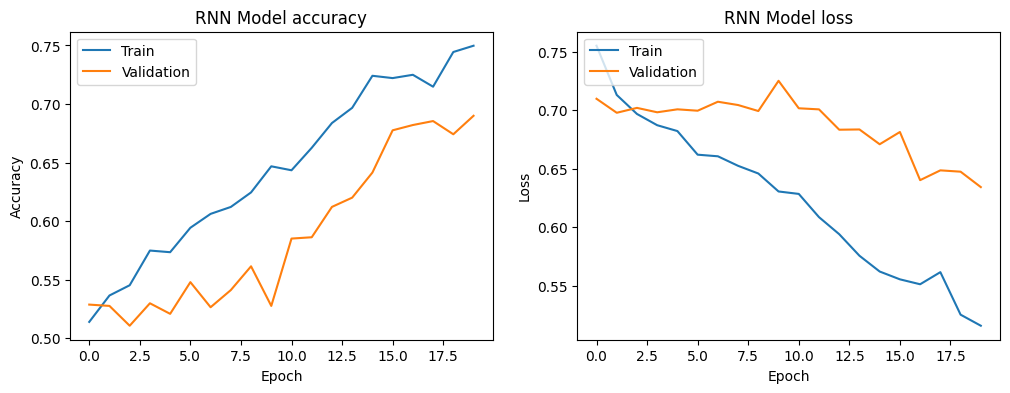

In [29]:
# Plot the training and validation loss and accuracy
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('RNN Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('RNN Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(RNN_history)

In [27]:
# Evaluate the model on the test set
test_loss, test_accuracy = RNNmodel.evaluate(X_test_RNN, y_test_RNN)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")



35/35 [==============================] - 2s 60ms/step - loss: 0.6392 - accuracy: 0.6796
Test Loss: 0.6392436623573303
Test Accuracy: 0.679602861404419


35/35 [==============================] - 7s 196ms/step


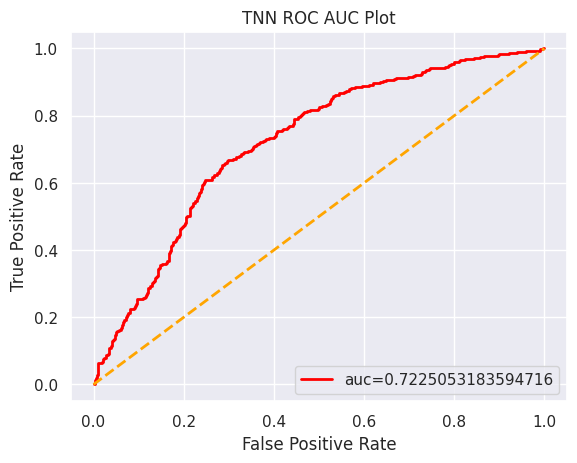

In [51]:
RNN_y_pred = RNNmodel.predict(X_test_RNN)
RNN_fpr, RNN_tpr, _ = roc_curve(y_test_RNN,  RNN_y_pred)
RNN_auc = roc_auc_score(y_test_RNN, RNN_y_pred)
plt.plot(RNN_fpr,RNN_tpr,label="auc="+str(RNN_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

CV-RNN

In [ ]:
# Define the RNN model
def RNN_model(input_shape, dropout_rate=0.2, output_units=1, output_activation='sigmoid', learning_rate=0.001, clipvalue=0.5):
    model = Sequential()
    model.add(SimpleRNN(50, input_shape=input_shape, return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(output_units, activation=output_activation))

    optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Prepare the data (Assuming X_train_RNN, y_train_RNN are defined)
X_train_RNN, X_test_RNN, y_train_RNN, y_test_RNN = X_train_NN.copy(), X_test_NN.copy(), y_train_NN.copy(), y_test_NN.copy()

# Perform cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_accuracies = []

for train_index, val_index in kf.split(X_train_RNN):
    X_train_fold, X_val_fold = X_train_RNN[train_index], X_train_RNN[val_index]
    y_train_fold, y_val_fold = y_train_RNN[train_index], y_train_RNN[val_index]

    RNN_cv_model = RNN_model(input_shape=(X_train_fold.shape[1], X_train_fold.shape[2]))
    RNN_cv_model.fit(X_train_fold, y_train_fold, epochs=15, batch_size=16, verbose=0)

    val_predictions_prob = RNN_cv_model.predict(X_val_fold)
    val_predictions = (val_predictions_prob > 0.5).astype(int)
    val_accuracy = accuracy_score(y_val_fold, val_predictions)
    cv_accuracies.append(val_accuracy)

print(f"Cross-Validation Accuracies: {cv_accuracies}")
print(f"Mean Cross-Validation Accuracy: {np.mean(cv_accuracies)}")

28/28 [==============================] - 3s 98ms/step
Cross-Validation Accuracies: [0.5749718151071026, 0.5422773393461104, 0.5372460496613995, 0.5496613995485328, 0.6534988713318285]
Mean Cross-Validation Accuracy: 0.5715310949989948


**Classic Machine Learning and ANN - feature extraction from processed EEG data**

**Frequency Domain features**\
Band Power Extraction

In [ ]:
def compute_psd_band_power(eeg_data, fs=128, bands={'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}):
    '''Calculate PSD band power for given EEG data without additional segmentation'''
    band_powers = []
    for channel_name in eeg_data.columns:
        channel = eeg_data[channel_name].values
        # Compute PSD using Welch's method
        freqs, psd = scipy.signal.welch(channel, fs=fs, nperseg=len(channel))
        channel_band_powers = []
        for band, (low, high) in bands.items():
            band_power = np.trapz(psd[(freqs >= low) & (freqs <= high)], freqs[(freqs >= low) & (freqs <= high)])
            channel_band_powers.append(band_power)
        band_powers.append(channel_band_powers)
    return np.array(band_powers).flatten()

def process_dataframes_to_band_powers(dataframes_dict, channel_names, bands):
    """
    Process each DataFrame in the dictionary to compute band powers.
    Store computed result into dataframe for each subject and use dictionary to hold all subject's dataframe together.
    """
    band_powers_dict = {}

    for key, df_ica in dataframes_dict.items():
        df_ica.columns = channel_names
        patient_band_powers = compute_psd_band_power(df_ica, bands=bands)

        feature_names = []
        for channel in channel_names:
            for band in bands.keys():
                feature_names.append(f"{channel}_{band}_power")

        band_powers_df = pd.DataFrame([patient_band_powers], columns=feature_names)
        band_powers_dict[key] = band_powers_df

    return band_powers_dict

In [ ]:
channel_names = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']
bands = {'theta': (4, 8), 'alpha': (8, 13), 'beta': (13, 30)}


band_powers_ADHD = process_dataframes_to_band_powers(dict_df_ADHD, channel_names, bands)
band_powers_Control = process_dataframes_to_band_powers(dict_df_Control, channel_names, bands)

In [ ]:
def convert_dict_to_df(dict):
    '''Function used to convert dictionary storing dataframes to a single dataframe'''
    combined_df = pd.concat(dict).reset_index(level=1, drop=True)
    combined_df.index.name = 'IDX'
    return combined_df

In [ ]:
band_powers_ADHD_df = convert_dict_to_df(band_powers_ADHD)
band_powers_Control_df = convert_dict_to_df(band_powers_Control)


**Time-Frequency Domain features**\
Wavelet Coefficient

In [ ]:
def extract_wavelet_features(eeg_data, wavelet='db4', levels=4):
    '''Extracting wavelet coefficient using wavelet transform method.'''
    features = []
    for channel_name in eeg_data.columns:
        channel = eeg_data[channel_name].values
        coeffs = pywt.wavedec(channel, wavelet, level=levels)
        channel_features = []
        # Only consider coefficients D4, D3, D2
        # Indices: 1 (D4), 2 (D3), 3 (D2)
        for i in range(1, levels):
            channel_features.append(np.mean(coeffs[i]))  # Mean
            channel_features.append(np.sum(coeffs[i] ** 2))  # Energy
        features.append(channel_features)
    return np.array(features).flatten()

def process_dataframes_to_wavelet_features(dataframes_dict, channel_names, wavelet='db4', levels=4):
    '''Process each DataFrame in the dictionary to extract wavelet features.'''
    wavelet_features_dict = {}

    for key, df_ica in dataframes_dict.items():
        df_ica.columns = channel_names
        wavelet_features = extract_wavelet_features(df_ica, wavelet, levels)
        wavelet_features_dict[key] = wavelet_features

    return wavelet_features_dict

def convert_wavelet_features_dict_to_df(wavelet_features_dict, channel_names):
    '''Convert the wavelet features dictionary to a DataFrame.'''
    all_features = np.array(list(wavelet_features_dict.values()))
    feature_labels = []
    for channel in channel_names:
        for level in ['D4', 'D3', 'D2']:
            feature_labels.append(f"{channel}_{level}_mean")
            feature_labels.append(f"{channel}_{level}_energy")

    return pd.DataFrame(all_features, columns=feature_labels, index=list(wavelet_features_dict.keys()))

In [ ]:
wavelet_features_ADHD = process_dataframes_to_wavelet_features(dict_df_ADHD, channel_names)
wavelet_features_Control = process_dataframes_to_wavelet_features(dict_df_Control, channel_names)

wavelet_features_ADHD_df = convert_wavelet_features_dict_to_df(wavelet_features_ADHD, channel_names)
wavelet_features_Control_df = convert_wavelet_features_dict_to_df(wavelet_features_Control, channel_names)

In [ ]:
wavelet_features_Control_df

,Fp1_D4_mean,Fp1_D4_energy,Fp1_D3_mean,Fp1_D3_energy,Fp1_D2_mean,Fp1_D2_energy,Fp2_D4_mean,Fp2_D4_energy,Fp2_D3_mean,Fp2_D3_energy,...,Cz_D3_mean,Cz_D3_energy,Cz_D2_mean,Cz_D2_energy,Pz_D4_mean,Pz_D4_energy,Pz_D3_mean,Pz_D3_energy,Pz_D2_mean,Pz_D2_energy
v305_seg_45,-18.256168,442651.960701,-4.088851,545261.759780,-4.427309,397492.511490,-2.210808,435251.998481,-1.224162,388356.633008,...,3.494546,351894.458309,0.942411,199338.403059,-6.599369,6.425681e+05,6.494026,350781.151343,1.308561,229775.143405
v305_seg_32,26.114646,400579.442023,2.640653,464661.799893,5.437000,294975.793278,21.921051,375466.152128,10.566091,648780.396797,...,0.675751,398237.671035,2.114949,182639.678870,31.988567,2.223229e+06,-17.430860,471835.789566,2.578999,289070.295108
v305_seg_21,-20.851145,355090.539629,10.540672,527311.284943,0.274569,335296.365744,1.660413,654033.452368,2.169884,302269.464017,...,-0.923822,846245.448738,-2.696333,155649.891530,0.632733,1.432976e+06,13.600439,728507.164835,-1.325399,220431.903416
v304_seg_30,-15.259594,151261.379314,3.710130,146111.173534,4.810747,168240.403716,-20.546992,273090.306494,4.504356,278794.348607,...,13.435607,209335.525654,-0.099227,56926.853464,-6.079591,6.326290e+05,7.350176,213585.191487,0.392627,51474.408456
v304_seg_24,-2.005253,444644.451635,7.013372,181151.529118,-1.905710,129787.453109,-32.003704,349357.147085,-6.100778,223969.788795,...,-14.002958,370596.812241,0.732148,90954.448217,17.332095,1.006394e+06,-7.280041,204696.259636,1.936113,97150.500493
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v116_seg_21,6.148932,471143.525560,7.238375,286036.237354,1.314786,176710.476234,3.846626,209455.809580,15.475814,205259.049367,...,6.565794,159210.078418,-0.067636,76933.597165,-14.568157,6.317273e+05,1.378291,296367.114433,1.838259,101704.451662
v117_seg_17,9.487410,385148.449037,7.644608,232086.931671,3.919904,140079.504257,-2.836750,454362.086414,8.332781,309276.567750,...,1.776160,312271.573006,-0.306415,65458.767412,-2.743342,3.244311e+05,-3.521678,197668.649340,0.679690,113283.167760
v116_seg_43,0.371218,230186.271385,5.830034,265538.171577,-2.111242,173647.455553,-5.528934,427820.640725,8.255683,189338.872599,...,0.349483,238197.834581,-0.774871,50148.719517,8.348357,4.597372e+05,-3.422978,288510.890567,-0.772992,124986.451210
v116_seg_33,19.700564,498940.120344,-6.230859,363648.619943,-3.594254,218033.418198,6.697584,366790.389961,-13.916827,119715.970508,...,-3.794220,136088.952194,-0.734985,78769.879214,15.868186,3.630508e+05,6.457280,316525.027890,0.935499,99585.548575


**Time Domain & Non-Linear features**\
Upload

In [ ]:
ADHD_MAT = pd.read_csv('/content/drive/MyDrive/DATASET/ADHD/Segmented/ADHD_matlab_features.csv')
Control_MAT = pd.read_csv('/content/drive/MyDrive/DATASET/ADHD/Segmented/Control_matlab_features.csv')

In [ ]:
ADHD_MAT = ADHD_MAT.set_index('FileName')
ADHD_MAT.index.name = None

Control_MAT = Control_MAT.set_index('FileName')
Control_MAT.index.name = None

**Data Manipulation**



In [ ]:
ADHD = pd.merge(band_powers_ADHD_df,
                wavelet_features_ADHD_df,
                how = 'left',
                left_index=True,
                right_index=True)

ADHD = pd.merge(ADHD,
                ADHD_MAT,
                how = 'left',
                left_index=True,
                right_index=True)

Control = pd.merge(band_powers_Control_df,
                wavelet_features_Control_df,
                how = 'left',
                left_index=True,
                right_index=True)

Control = pd.merge(Control,
                Control_MAT,
                how = 'left',
                left_index=True,
                right_index=True)

In [ ]:
# Create Target column
ADHD['Target'] = 1
Control['Target'] = 0

In [ ]:
# Concat into complete dataset
ADHD_dataset = pd.concat([ADHD,Control])

In [ ]:
ADHD_dataset

,Fp1_theta_power,Fp1_alpha_power,Fp1_beta_power,Fp2_theta_power,Fp2_alpha_power,Fp2_beta_power,F3_theta_power,F3_alpha_power,F3_beta_power,F4_theta_power,...,Pz_HC,Pz_SD,Pz_Var,Pz_Skew,Pz_Kurts,Pz_AM,Pz_KatzFD,Pz_LyapExp,Pz_HurstEx,Target
IDX,,,,,,,,,,,,,,,,,,,,,
v10p_seg_25,351.198691,604.232994,307.888490,260.166892,242.760361,304.356654,2725.194694,2584.162539,1020.701864,2033.073914,...,1.618348,58.630867,3437.578510,0.275097,4.454721,0.020569,2.017541,37.472857,0.414891,1
v10p_seg_20,508.908200,486.985406,286.899382,881.792913,431.618741,263.513096,938.769579,1010.075063,652.829330,1928.807407,...,1.954760,65.261880,4259.112972,-0.327403,5.455718,-0.047895,1.978097,41.448460,0.482580,1
v10p_seg_21,470.794016,297.963984,306.434496,330.469983,588.790915,333.835102,1100.372581,851.095073,888.156523,731.441761,...,1.680338,57.420497,3297.113481,0.303789,4.131550,-0.006651,2.022030,39.766747,0.413359,1
v10p_seg_22,253.822890,198.916968,192.052114,452.609526,289.892899,330.504049,995.542086,317.821354,665.028027,1810.762884,...,1.614325,45.746421,2092.735064,-0.736904,6.306586,0.028757,1.911475,35.214267,0.407152,1
v10p_seg_19,565.184568,530.239736,192.517977,388.304420,403.170750,227.945715,2013.628052,515.876565,803.068160,1265.246437,...,1.630103,55.979541,3133.708981,0.064008,5.530199,0.049834,1.964633,43.218611,0.402959,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v60p_seg_19,8636.065411,2296.294808,2530.791677,6962.946039,1229.792482,1499.258806,11449.683475,2937.679381,3480.870456,9823.774144,...,2.627980,182.691199,33376.074356,-0.408041,4.643646,-0.028150,2.141044,37.799306,0.478960,0
v60p_seg_22,2236.341203,1241.333202,3009.015138,2735.297512,1567.832223,3420.770543,2868.684279,1456.523879,2355.526910,5292.744035,...,2.011516,112.804929,12724.952117,0.007278,3.755345,0.233043,2.265175,46.484706,0.437628,0
v60p_seg_17,11903.237564,3646.387955,2935.389620,6271.196649,3659.052934,836.395259,17112.633724,3730.500381,3413.799461,7413.297467,...,2.229390,179.941541,32378.958270,-0.244820,5.692636,0.200169,2.219095,45.111449,0.491316,0


**Theta/Beta ratio _ PSD**

In [ ]:
def compute_ratios(dataframe, channels):
    '''Computes theta/beta and D4/D2 ratios for each channel and adds them to the DataFrame.'''
    for channel in channels:
        # Compute theta/beta ratio
        theta_col = f'{channel}_theta_power'
        beta_col = f'{channel}_beta_power'
        theta_beta_ratio_col = f'{channel}_Theta_Beta'

        if theta_col in dataframe.columns and beta_col in dataframe.columns:
            dataframe[theta_beta_ratio_col] = dataframe[theta_col] / dataframe[beta_col]

    return dataframe

In [ ]:
channels = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'Fz', 'Cz', 'Pz']

# Compute ratios
ADHD_dataset = compute_ratios(ADHD_dataset, channels)

In [ ]:
ADHD_dataset

,Fp1_theta_power,Fp1_alpha_power,Fp1_beta_power,Fp2_theta_power,Fp2_alpha_power,Fp2_beta_power,F3_theta_power,F3_alpha_power,F3_beta_power,F4_theta_power,...,O2_Theta_Beta,F7_Theta_Beta,F8_Theta_Beta,T7_Theta_Beta,T8_Theta_Beta,P7_Theta_Beta,P8_Theta_Beta,Fz_Theta_Beta,Cz_Theta_Beta,Pz_Theta_Beta
IDX,,,,,,,,,,,,,,,,,,,,,
v279_seg_49,1949.266595,1750.811371,1988.126209,2530.280993,2755.149669,1873.338284,1752.585474,1266.475506,995.680153,2100.921661,...,1.400962,1.743988,1.590537,3.533235,3.018528,1.186517,1.092198,1.614206,8.712735,3.557456
v27p_seg_33,558.043950,573.186005,1876.069236,900.650220,673.718624,747.984890,844.772183,805.823123,944.100202,666.178442,...,1.874877,1.479444,1.636821,2.610539,0.485245,4.807080,116.635206,1.272972,0.582960,1.093169
v27p_seg_12,5844.682917,1127.529483,1867.382517,5255.741239,1352.601057,1330.751539,1351.690161,1023.389443,438.732181,797.597546,...,1.251737,2.093599,0.283623,1.596810,0.781144,1.689104,12.239977,3.518638,0.445648,0.270879
v27p_seg_52,10279.718019,1418.702680,1357.513169,17161.115108,1425.838081,1102.332952,943.184632,1473.901347,490.576926,1457.370260,...,2.643629,2.304357,2.020886,3.535251,2.179532,3.836998,12.941024,3.277502,2.793986,0.662594
v27p_seg_51,2528.065594,1201.476333,1713.237916,2550.819771,561.183474,1493.398811,651.802774,765.392425,647.310174,573.371822,...,1.569465,1.397477,0.714023,2.262657,0.532365,2.766404,38.754475,1.010284,0.991385,0.524379
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
v116_seg_21,1370.615803,667.845484,874.212161,1089.583888,274.321359,699.655859,899.096421,396.301906,348.514757,911.170289,...,1.909524,2.694800,1.225764,4.279237,1.208983,1.532528,1.819936,1.469809,4.216444,5.660560
v117_seg_17,1371.665294,424.963151,770.348936,1672.489394,575.645392,798.248122,1196.491467,266.896368,374.786266,1287.750522,...,0.892800,2.841756,1.995861,4.881753,2.301716,1.938376,6.447367,1.378372,10.332617,1.845600
v116_seg_43,1206.530067,776.354744,881.450044,1692.837987,426.864628,416.347593,616.504443,259.194429,255.896637,919.741894,...,2.351113,4.939074,4.642585,6.980921,5.039008,3.442862,2.883592,2.004033,6.455533,3.550720


In [ ]:
# Save file locally for checkpoint
from google.colab import files
ADHD_dataset.to_csv('ADHD_dataset_colab_seg.csv', index=False)
files.download('ADHD_dataset_colab_seg.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [13]:
# Upload files from checkpoint
ADHD_dataset = pd.read_csv('/content/drive/MyDrive/DATASET/ADHD/ADHD_dataset_colab_seg.csv')

**Machine Learning Model Training**\
Initial model without tuning

In [16]:
X = ADHD_dataset.drop(['Target'], axis = 1)
y = ADHD_dataset['Target']

In [17]:
# Split Data for training and test sets
X_train , X_test , y_train , y_test = train_test_split(X, y,test_size = 0.20,random_state = 19)

scaler = StandardScaler()
X_train_1= scaler.fit_transform(X_train)
X_test_1= scaler.transform(X_test)

In [ ]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    """
    Trains given classifiers on the training data, makes predictions on the test data,
    evaluates the models, and plots their confusion matrices.
    """
    results = {}
    for name, classifier in classifiers.items():
        # Fit the model
        classifier.fit(X_train, y_train)

        # Predict & Evaluate
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Classifier Accuracy:", accuracy)

        training_accuracy = classifier.score(X_train, y_train)
        print(f"{name} Training Accuracy:", training_accuracy)

        # Store accuracy in results
        results[f"{name}_Accuracy"] = accuracy

        # Confusion Matrix
        conf_mat = confusion_matrix(y_test, y_pred)
        #print(f"{name} Confusion Matrix:\n", conf_mat)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

        # Plotting Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1)
        sns.heatmap(conf_mat, fmt='d', cmap='rocket', annot=True, linewidth=.5)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()


        # ROC AUC
        y_pred_prob = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        roc_auc = auc(fpr, tpr)
        results[f"{name}_AUC"] = roc_auc

        # Plotting ROC AUC
        plt.plot(fpr, tpr, lw=2, label=f'{name} (AUC = {roc_auc:.2f})')

        print('---------------------------------------------------------------------')

    # Plot ROC AUC for all classifiers
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC AUC Curves')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

    return results

In [52]:
def evaluate_classifiers(classifiers, X_train, y_train, X_test, y_test):
    """
    Trains given classifiers on the training data, makes predictions on the test data,
    evaluates the models, and plots their confusion matrices.
    """
    results = {}
    for name, classifier in classifiers.items():
        # Fit the model
        classifier.fit(X_train, y_train)

        # Predict & Evaluate
        y_pred = classifier.predict(X_test)
        accuracy = accuracy_score(y_test, y_pred)
        print(f"{name} Classifier Accuracy:", accuracy)

        training_accuracy = classifier.score(X_train, y_train)
        print(f"{name} Training Accuracy:", training_accuracy)

        # Store accuracy in results
        results[f"{name}_Accuracy"] = accuracy

        # Confusion Matrix
        conf_mat = confusion_matrix(y_test, y_pred)
        print(f"{name} Classification Report:\n", classification_report(y_test, y_pred))

        # Plotting Confusion Matrix
        plt.figure(figsize=(8, 6))
        sns.set(font_scale=1)
        sns.heatmap(conf_mat, fmt='d', cmap='rocket', annot=True, linewidth=.5)
        plt.title(f'{name} Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

        # ROC AUC
        y_pred_prob = classifier.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        results[f"{name}_y_pred_prob"] = y_pred_prob
        results[f"{name}_AUC"] = roc_auc_score(y_test, y_pred_prob)
        results[f"{name}_FPR"] = fpr
        results[f"{name}_TPR"] = tpr

        print('---------------------------------------------------------------------')

    return results


In [53]:
RF_classif = RandomForestClassifier(n_estimators=100,random_state=19)
XGB_classif = xgb.XGBClassifier(objective="binary:logistic", random_state=19)
DT_classif = DecisionTreeClassifier(random_state=19)



classifier = {
    'Random Forest':RF_classif,
    'XGBoost':XGB_classif,
    'Decision Tree':DT_classif
}


Random Forest Classifier Accuracy: 0.9557761732851986
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       487
           1       0.94      0.98      0.96       621

    accuracy                           0.96      1108
   macro avg       0.96      0.95      0.95      1108
weighted avg       0.96      0.96      0.96      1108



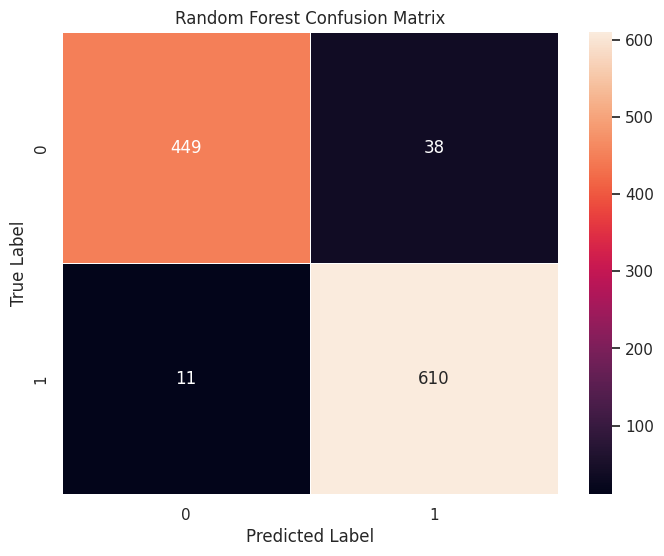

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9711191335740073
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.97       487
           1       0.96      0.99      0.97       621

    accuracy                           0.97      1108
   macro avg       0.97      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108



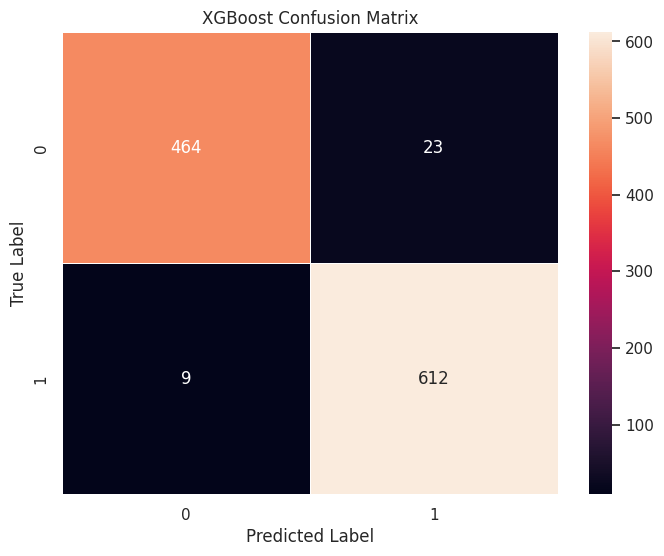

---------------------------------------------------------------------
Decision Tree Classifier Accuracy: 0.8438628158844765
Decision Tree Training Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82       487
           1       0.86      0.86      0.86       621

    accuracy                           0.84      1108
   macro avg       0.84      0.84      0.84      1108
weighted avg       0.84      0.84      0.84      1108



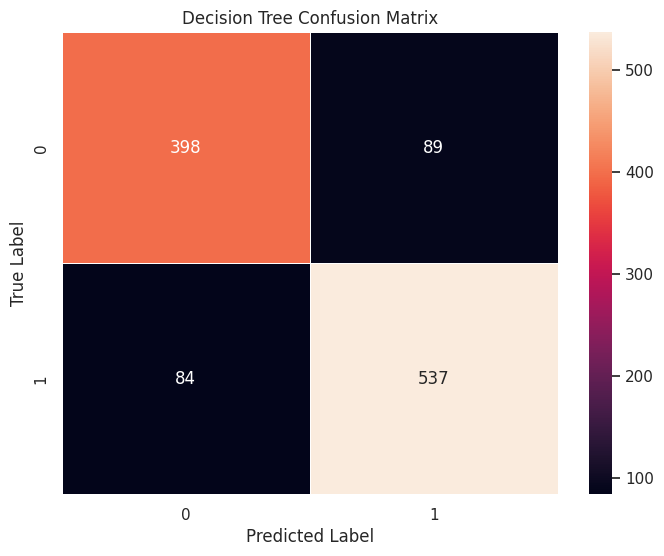

---------------------------------------------------------------------


In [57]:
accuracy_all = evaluate_classifiers(classifier, X_train_1, y_train, X_test_1, y_test)

**Artificial Neural Network - Initial Model before feature selection and tuning**

In [35]:
# Copy of train and test set
X_train_ANN, X_test_ANN, y_train_ANN, y_test_ANN = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

# Scaling
scaler = StandardScaler()
X_train_ANN = scaler.fit_transform(X_train_ANN)
X_test_ANN= scaler.transform(X_test_ANN)

In [36]:
def ANN_model(input_shape, learning_rate=0.001, activation='relu'):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate, clipvalue=0.5)

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])

    return model

In [37]:
MLPModel = ANN_model(input_shape=[X_train_ANN.shape[1]])

In [38]:
history_ANN = MLPModel.fit(X_train_ANN, y_train_ANN, epochs=15, validation_split= 0.2)

Epoch 1/15
111/111 [==============================] - 2s 7ms/step - loss: 0.5069 - accuracy: 0.7551 - val_loss: 0.4104 - val_accuracy: 0.8038
Epoch 2/15
111/111 [==============================] - 0s 4ms/step - loss: 0.2664 - accuracy: 0.8984 - val_loss: 0.3142 - val_accuracy: 0.8737
Epoch 3/15
111/111 [==============================] - 1s 5ms/step - loss: 0.1513 - accuracy: 0.9543 - val_loss: 0.2729 - val_accuracy: 0.9064
Epoch 4/15
111/111 [==============================] - 1s 6ms/step - loss: 0.0883 - accuracy: 0.9774 - val_loss: 0.2912 - val_accuracy: 0.9087
Epoch 5/15
111/111 [==============================] - 1s 5ms/step - loss: 0.0512 - accuracy: 0.9910 - val_loss: 0.2586 - val_accuracy: 0.9256
Epoch 6/15
111/111 [==============================] - 1s 5ms/step - loss: 0.0319 - accuracy: 0.9961 - val_loss: 0.3198 - val_accuracy: 0.9200
Epoch 7/15
111/111 [==============================] - 1s 5ms/step - loss: 0.0242 - accuracy: 0.9977 - val_loss: 0.3623 - val_accuracy: 0.9245
Epoch 

In [ ]:
def plot_learning_curve(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('MLP Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('MLP Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

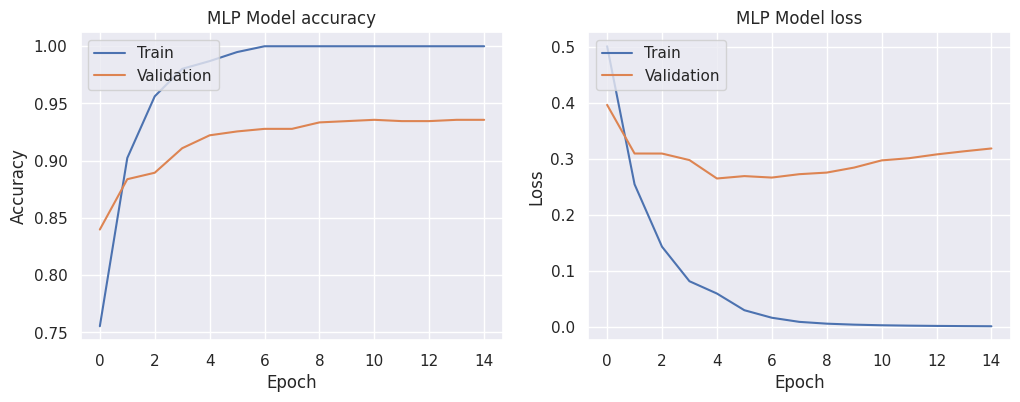

In [ ]:
plot_learning_curve(history_ANN)

In [39]:
MLPModel.evaluate(X_test_ANN, y_test_ANN)

35/35 [==============================] - 0s 2ms/step - loss: 0.2425 - accuracy: 0.9386


[0.24249349534511566, 0.9386281371116638]

35/35 [==============================] - 0s 5ms/step


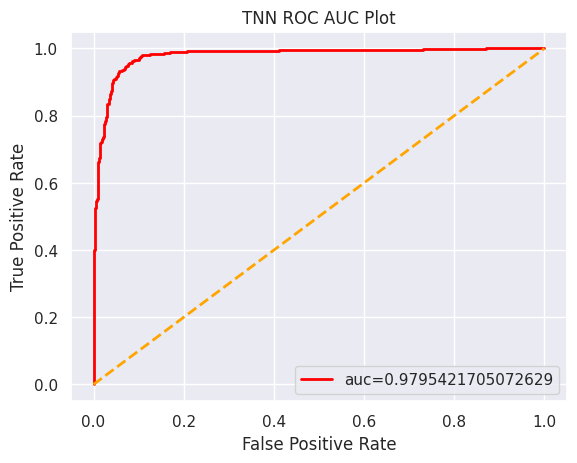

In [50]:
MLP_y_pred = MLPModel.predict(X_test_ANN)
MLP_fpr, MLP_tpr, _ = roc_curve(y_test_ANN,  MLP_y_pred)
MLP_auc = roc_auc_score(y_test_ANN, MLP_y_pred)
plt.plot(MLP_fpr,MLP_tpr,label="auc="+str(MLP_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

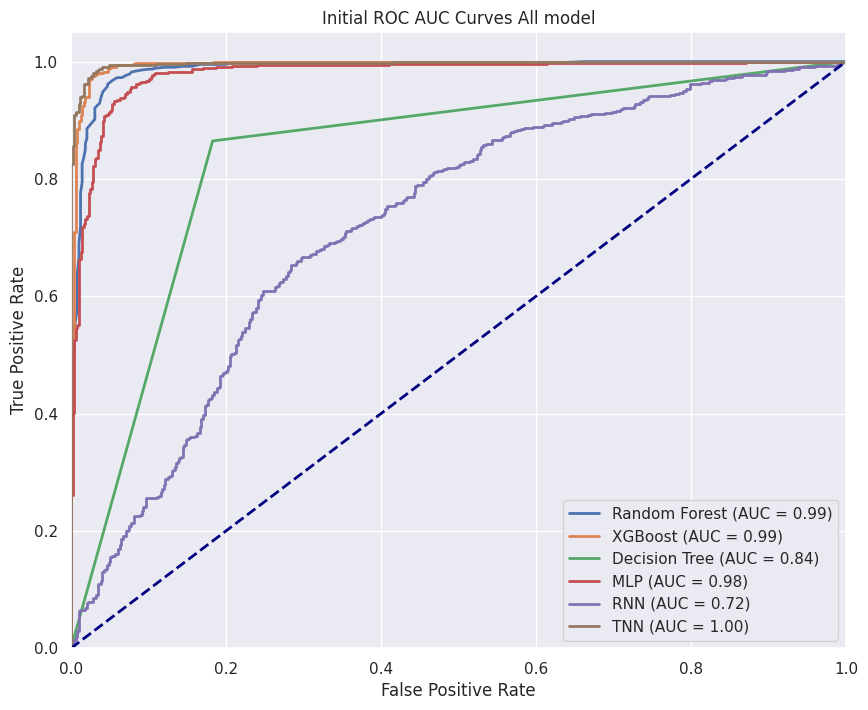

In [61]:
# Create a dictionary to store all ROC AUC information
roc_auc_dict = {
    'Random Forest': {
        'fpr': accuracy_all['Random Forest_FPR'],
        'tpr': accuracy_all['Random Forest_TPR'],
        'auc': accuracy_all['Random Forest_AUC']
    },
    'XGBoost': {
        'fpr': accuracy_all['XGBoost_FPR'],
        'tpr': accuracy_all['XGBoost_TPR'],
        'auc': accuracy_all['XGBoost_AUC']
    },
    'Decision Tree': {
        'fpr': accuracy_all['Decision Tree_FPR'],
        'tpr': accuracy_all['Decision Tree_TPR'],
        'auc': accuracy_all['Decision Tree_AUC']
    },
    'MLP': {
        'fpr': MLP_fpr,
        'tpr': MLP_tpr,
        'auc': MLP_auc
    },
    'RNN': {
        'fpr': RNN_fpr,
        'tpr': RNN_tpr,
        'auc': RNN_auc
    },
    'TNN': {
        'fpr': TNN_fpr,
        'tpr': TNN_tpr,
        'auc': TNN_auc
    }
}

# Now plot the ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, roc_data in roc_auc_dict.items():
    plt.plot(roc_data['fpr'], roc_data['tpr'], lw=2, label=f'{model_name} (AUC = {roc_data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Initial ROC AUC Curves All model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


**Feature Selection**

K-best (Mutual Information)

In [ ]:
# Copy of train and test set
X_train_kb, X_test_kb, y_train_kb, y_test_kb = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def scale_data(X_train, X_test, scaler=StandardScaler()):
    """
    Scales the training and testing data and converts them back to DataFrames.
    """
    # Fit the scaler on the training data
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convert the scaled data back to DataFrames
    X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)
    X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns)

    return X_train_scaled, X_test_scaled

X_train_kb, X_test_kb = scale_data(X_train.copy(), X_test.copy())

In [ ]:
def get_selected_features(X_train, y_train, max_ac_index):
    """
    Select features using SelectKBest with mutual_info_classif.
    """
    selector = SelectKBest(mutual_info_classif, k=max_ac_index)
    selector.fit(X_train, y_train)

    selected_feature_mask = selector.get_support()
    selected_features_KB = X_train.columns[selected_feature_mask]

    return selected_features_KB

In [ ]:
def kbest_feature_selection(X_train, y_train, X_test, y_test, classifiers, max_features):
    """
    Evaluates classifier performance over a range of features selected using SelectKBest.

    """
    results = {}

    for name, classifier in classifiers.items():
        accuracy_score_KB = []
        print(f"Evaluating {name}...")

        for k in tqdm(range(1, max_features + 1)):
            # Feature selection
            selector = SelectKBest(mutual_info_classif, k=k)
            selector.fit(X_train, y_train)

            sel_X_train = selector.transform(X_train)
            sel_X_test = selector.transform(X_test)

            # Training the classifier
            classifier.fit(sel_X_train, y_train)
            predictions = classifier.predict(sel_X_test)

            # Calculating the F1 score
            accuracy_kbest = round(f1_score(y_test, predictions, average='weighted'), 3)
            accuracy_score_KB.append(accuracy_kbest)

        # Find the index and value of the maximum F1 score
        max_ac_index = np.argmax(accuracy_score_KB)
        max_ac_value_KB = accuracy_score_KB[max_ac_index]

        selected_features_KB = get_selected_features(X_train, y_train, max_ac_index)

        results[name] = (accuracy_score_KB, max_ac_value_KB, max_ac_index, selected_features_KB)
        print(f"{name} best index:{max_ac_index} ; best accuracy score: {max_ac_value_KB}")

    return results

In [ ]:
max_features = 399

XGB_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=19)

classifiers = {
    'XGBoost':XGB_classifier
}

K_Best = kbest_feature_selection(X_train_kb, y_train_kb, X_test_kb, y_test_kb, classifiers, max_features)

Evaluating XGBoost...


100%|██████████| 399/399 [1:12:03<00:00, 10.84s/it]


XGBoost best index:264 ; best accuracy score: 0.982


**Model Training & Testing**\
with features obtained from K-Best (XGBoost)

In [ ]:
selected_features_XGB = K_Best['XGBoost'][3]

In [ ]:
selected_features_XGB

Index(['Fp1_alpha_power', 'Fp2_theta_power', 'Fp2_beta_power',
       'F3_theta_power', 'F3_alpha_power', 'F3_beta_power', 'F4_theta_power',
       'F4_alpha_power', 'F4_beta_power', 'C3_theta_power',
       ...
       'P4_Theta_Beta', 'O1_Theta_Beta', 'O2_Theta_Beta', 'F8_Theta_Beta',
       'T8_Theta_Beta', 'P7_Theta_Beta', 'P8_Theta_Beta', 'Fz_Theta_Beta',
       'Cz_Theta_Beta', 'Pz_Theta_Beta'],
      dtype='object', length=264)

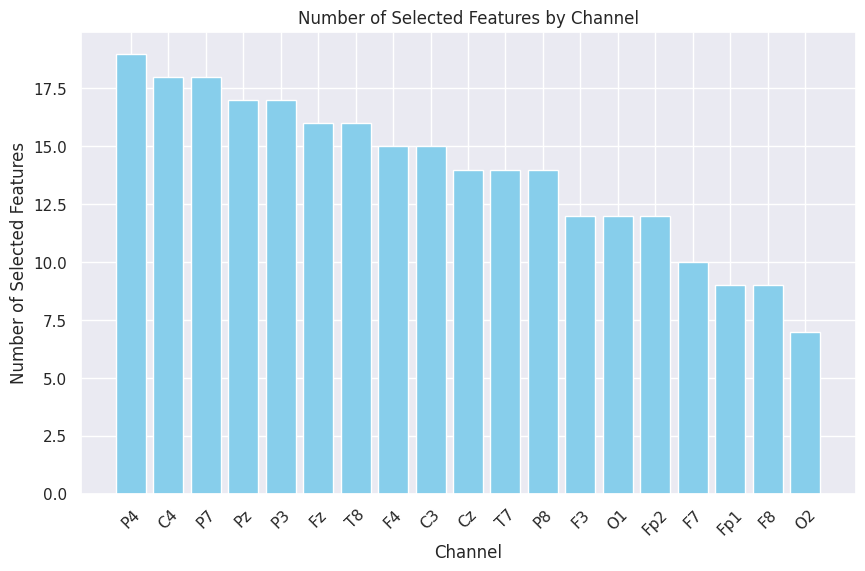

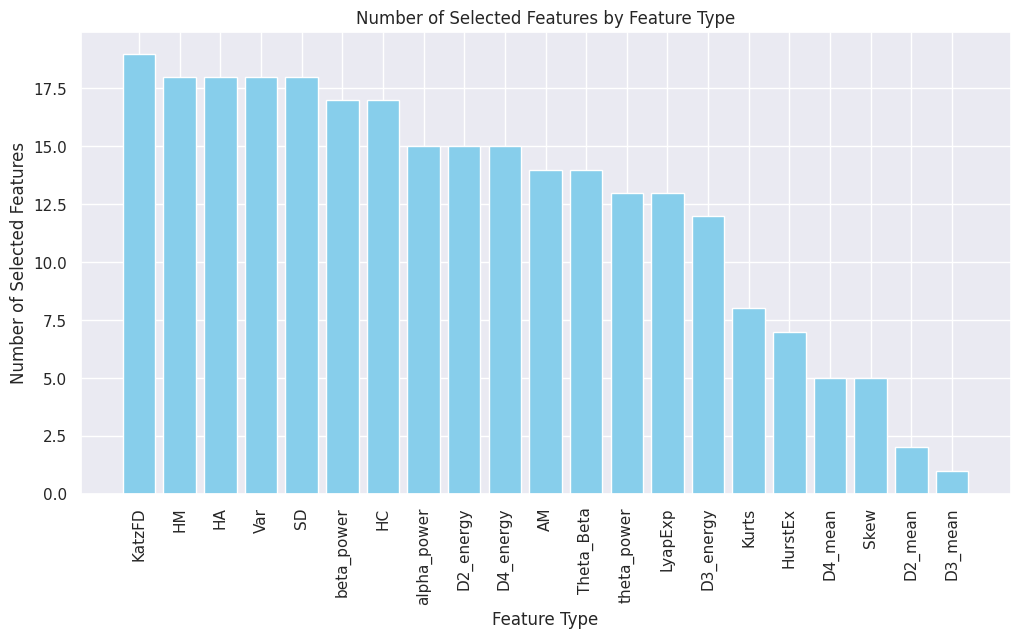

In [ ]:
selected_features = selected_features_XGB

channels = [feature.split('_')[0] for feature in selected_features]
channel_counts = Counter(channels)
channel_df = pd.DataFrame(channel_counts.items(), columns=['Channel', 'Count']).sort_values(by='Count', ascending=False)


feature_types = ['_'.join(feature.split('_')[1:]) for feature in selected_features]
feature_type_counts = Counter(feature_types)
feature_type_df = pd.DataFrame(feature_type_counts.items(), columns=['Feature Type', 'Count']).sort_values(by='Count', ascending=False)

plt.figure(figsize=(10, 6))
plt.bar(channel_df['Channel'], channel_df['Count'], color='skyblue')
plt.xlabel('Channel')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features by Channel')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(12, 6))
plt.bar(feature_type_df['Feature Type'], feature_type_df['Count'], color='skyblue')
plt.xlabel('Feature Type')
plt.ylabel('Number of Selected Features')
plt.title('Number of Selected Features by Feature Type')
plt.xticks(rotation=90)
plt.show()


In [ ]:
X_FS, y_FS = X.copy(), y.copy()

X_FS = X_FS[selected_features_XGB]

X_train_FS , X_test_FS , y_train_FS , y_test_FS = train_test_split(X_FS, y_FS,test_size = 0.20,random_state = 19)

Random Forest Classifier Accuracy: 0.9575812274368231
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.92      0.95       487
           1       0.94      0.99      0.96       621

    accuracy                           0.96      1108
   macro avg       0.96      0.95      0.96      1108
weighted avg       0.96      0.96      0.96      1108



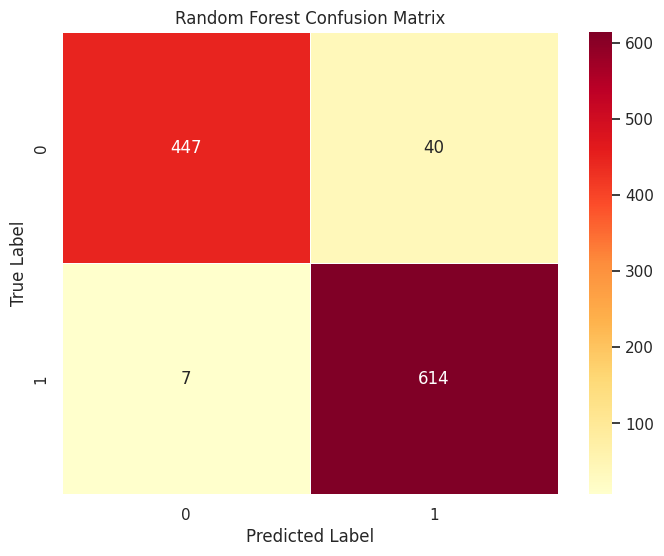

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9657039711191335
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.94      0.96       487
           1       0.96      0.98      0.97       621

    accuracy                           0.97      1108
   macro avg       0.97      0.96      0.97      1108
weighted avg       0.97      0.97      0.97      1108



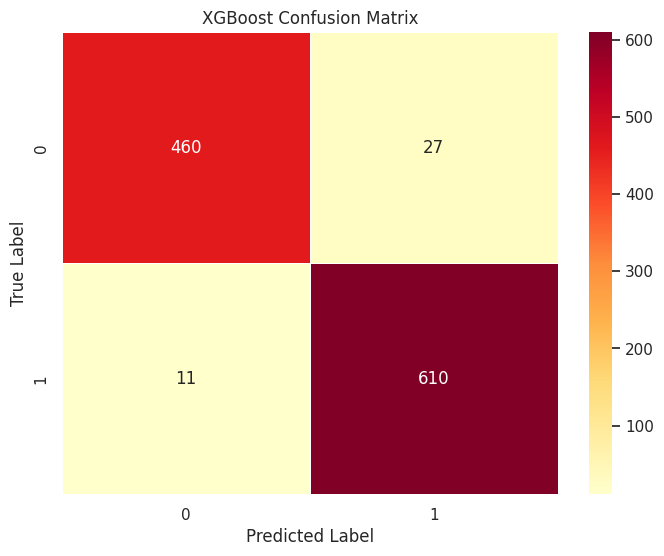

---------------------------------------------------------------------
Decision Tree Classifier Accuracy: 0.8393501805054152
Decision Tree Training Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.83      0.82       487
           1       0.86      0.85      0.86       621

    accuracy                           0.84      1108
   macro avg       0.84      0.84      0.84      1108
weighted avg       0.84      0.84      0.84      1108



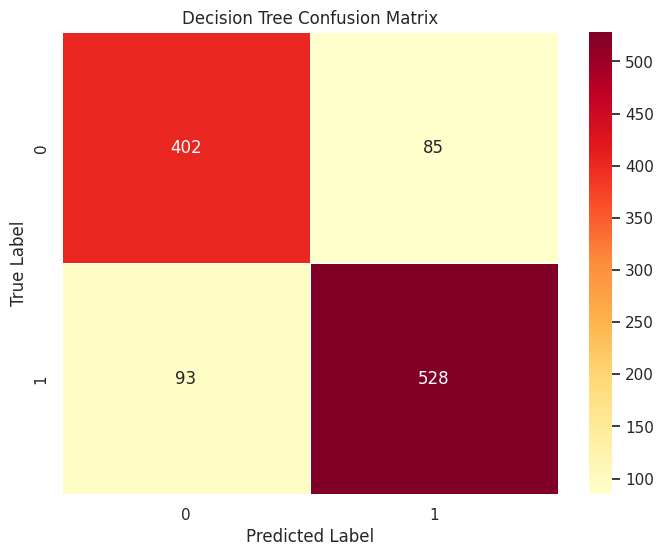

---------------------------------------------------------------------


In [ ]:
RF_classifier = RandomForestClassifier(n_estimators=100,random_state=19)
XGB_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=19)
DT_classifier = DecisionTreeClassifier(random_state=19)


classifier = {
    'Random Forest':RF_classifier,
    'XGBoost':XGB_classifier,
    'Decision Tree':DT_classifier
}
accuracy_FS = evaluate_classifiers(classifier, X_train_FS, y_train_FS, X_test_FS, y_test_FS)

**MLP-NN_KBEST**

In [ ]:
X_train_ANN_KB, X_test_ANN_KB, y_train_ANN_KB, y_test_ANN_KB = X_train_FS.copy() , X_test_FS.copy() , y_train_FS.copy() , y_test_FS.copy()
# Scaling
scaler = StandardScaler()
X_train_ANN_KB = scaler.fit_transform(X_train_ANN_KB)
X_test_ANN_KB= scaler.transform(X_test_ANN_KB)


In [ ]:
ANN_KB_model = ANN_model(input_shape=[X_train_ANN_KB.shape[1]])
history_ANN_KB = ANN_KB_model.fit(X_train_ANN_KB, y_train_ANN_KB, epochs=20)

Epoch 1/20
139/139 [==============================] - 1s 3ms/step - loss: 0.4886 - accuracy: 0.7613
Epoch 2/20
139/139 [==============================] - 0s 3ms/step - loss: 0.2582 - accuracy: 0.9041
Epoch 3/20
139/139 [==============================] - 0s 3ms/step - loss: 0.1535 - accuracy: 0.9463
Epoch 4/20
139/139 [==============================] - 0s 3ms/step - loss: 0.1028 - accuracy: 0.9659
Epoch 5/20
139/139 [==============================] - 0s 3ms/step - loss: 0.0688 - accuracy: 0.9801
Epoch 6/20
139/139 [==============================] - 0s 3ms/step - loss: 0.0418 - accuracy: 0.9905
Epoch 7/20
139/139 [==============================] - 0s 3ms/step - loss: 0.0292 - accuracy: 0.9944
Epoch 8/20
139/139 [==============================] - 1s 4ms/step - loss: 0.0182 - accuracy: 0.9986
Epoch 9/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0129 - accuracy: 0.9989
Epoch 10/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0079 - accuracy: 1.0000

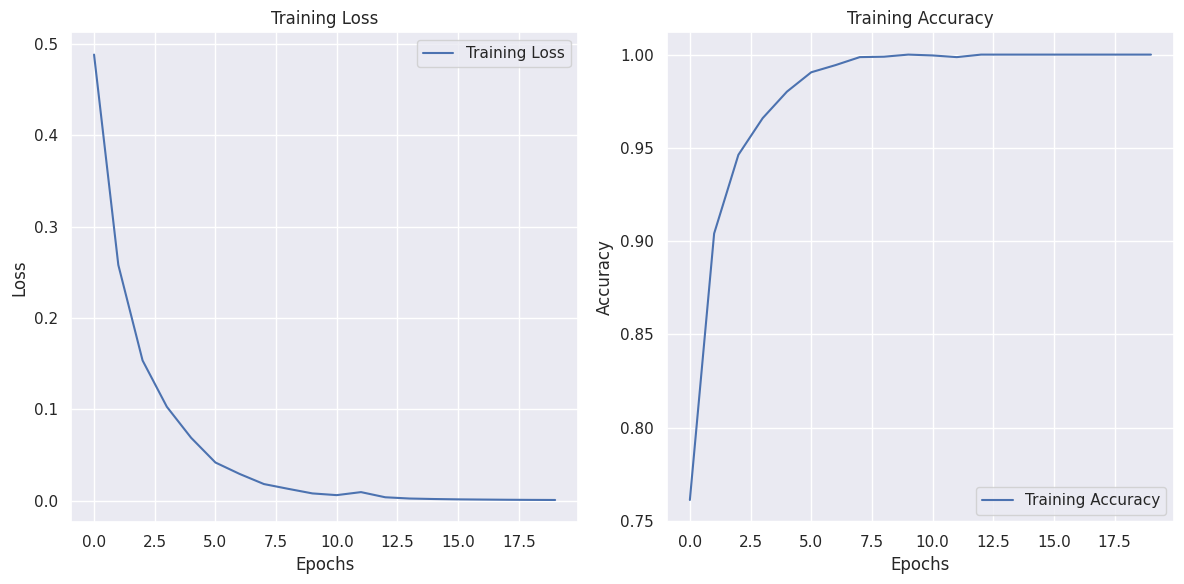

35/35 [==============================] - 0s 2ms/step - loss: 0.1472 - accuracy: 0.9666


[0.14718210697174072, 0.9666064977645874]

In [ ]:
plot_learning_curve(history_ANN_KB)
ANN_KB_model.evaluate(X_test_ANN_KB, y_test_ANN_KB)

**Tree Based Selection**

In [63]:
X_train_tree, X_test_tree, y_train_tree, y_test_tree = X_train.copy(), X_test.copy(), y_train.copy(), y_test.copy()

def tree_based_feature_selection(X_train, y_train):
    model = xgb.XGBClassifier(objective="binary:logistic", random_state = 42)
    model.fit(X_train, y_train)
    model = SelectFromModel(model, prefit=True)
    return X_train.columns[model.get_support()]

selected_features_tree = tree_based_feature_selection(X_train_tree, y_train_tree)
print("Selected features by tree-based selection:", selected_features_tree)


Selected features by tree-based selection: Index(['Fp1_alpha_power', 'Fp1_beta_power', 'Fp2_theta_power', 'F3_beta_power',
       'F4_beta_power', 'C3_beta_power', 'C4_alpha_power', 'P3_beta_power',
       'F7_beta_power', 'F8_alpha_power',
       ...
       'Cz_HurstEx', 'Pz_HA', 'Pz_HM', 'Pz_HC', 'Pz_KatzFD', 'Pz_LyapExp',
       'Fp2_Theta_Beta', 'F3_Theta_Beta', 'P4_Theta_Beta', 'T8_Theta_Beta'],
      dtype='object', length=137)


<ipython-input-64-1516960cfc47>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[0], x='Channel', y='Count', data=channel_df, palette='Blues_d')
<ipython-input-64-1516960cfc47>:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(ax=axes[1], x='Feature Type', y='Count', data=feature_type_df, palette='Blues_d')


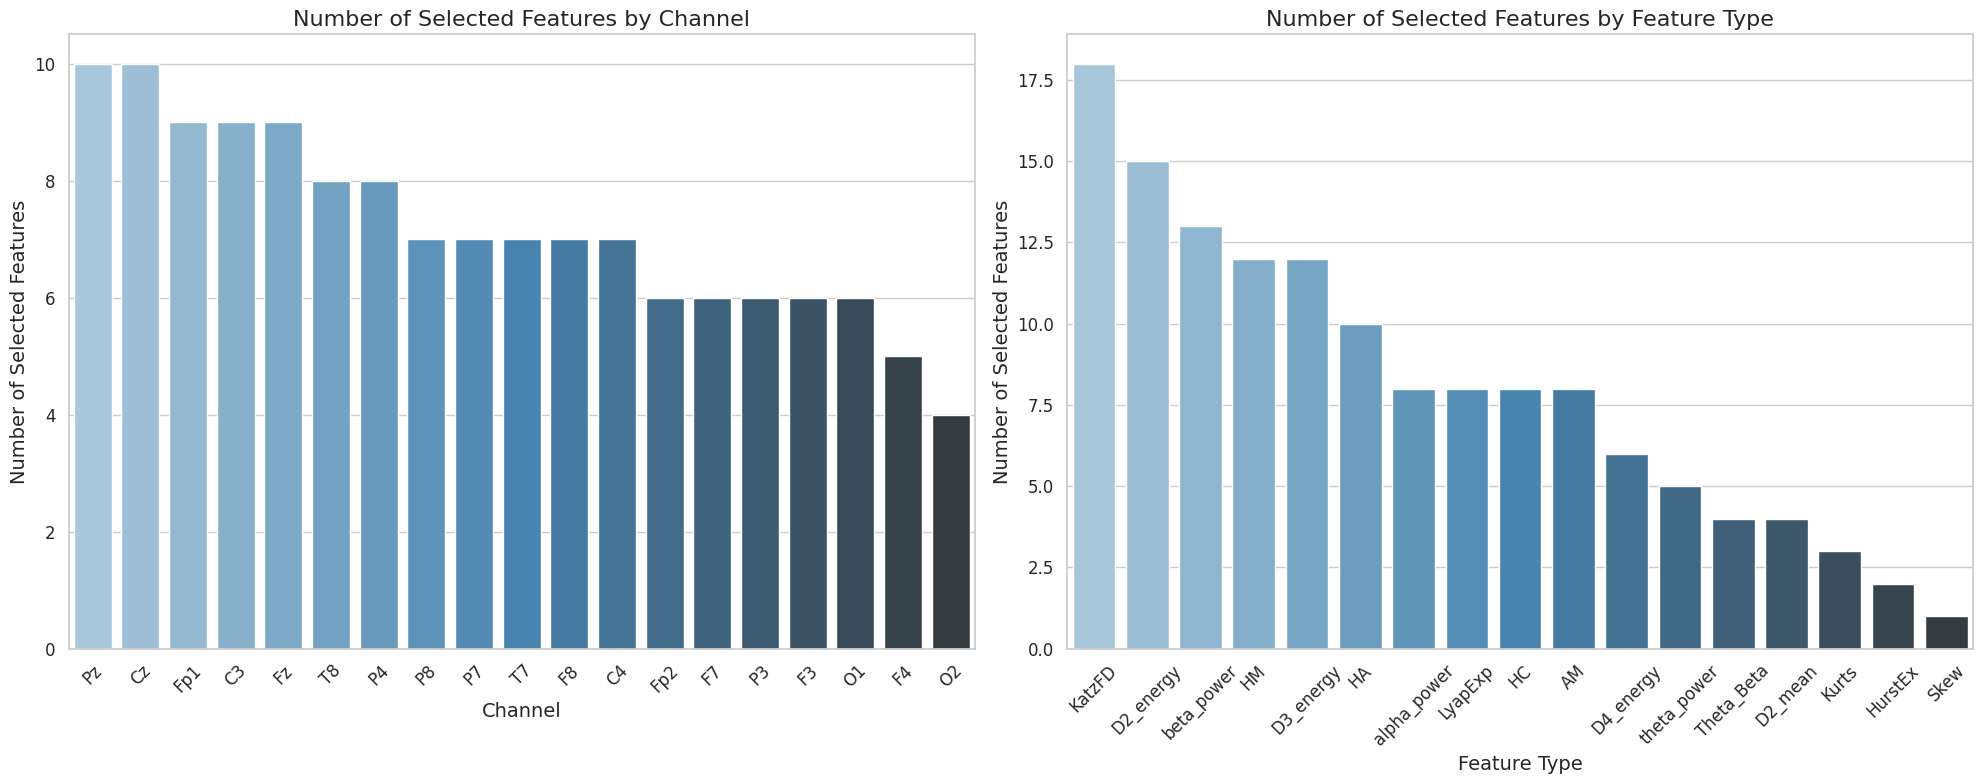

In [64]:
selected_features = selected_features_tree

channels = [feature.split('_')[0] for feature in selected_features]
channel_counts = Counter(channels)
channel_df = pd.DataFrame(channel_counts.items(), columns=['Channel', 'Count']).sort_values(by='Count', ascending=False)

feature_types = ['_'.join(feature.split('_')[1:]) for feature in selected_features]
feature_type_counts = Counter(feature_types)
feature_type_df = pd.DataFrame(feature_type_counts.items(), columns=['Feature Type', 'Count']).sort_values(by='Count', ascending=False)


sns.set(style="whitegrid")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))

sns.barplot(ax=axes[0], x='Channel', y='Count', data=channel_df, palette='Blues_d')
axes[0].set_xlabel('Channel', fontsize=14)
axes[0].set_ylabel('Number of Selected Features', fontsize=14)
axes[0].set_title('Number of Selected Features by Channel', fontsize=16)
axes[0].tick_params(axis='x', rotation=45, labelsize=12)
axes[0].tick_params(axis='y', labelsize=12)

sns.barplot(ax=axes[1], x='Feature Type', y='Count', data=feature_type_df, palette='Blues_d')
axes[1].set_xlabel('Feature Type', fontsize=14)
axes[1].set_ylabel('Number of Selected Features', fontsize=14)
axes[1].set_title('Number of Selected Features by Feature Type', fontsize=16)
axes[1].tick_params(axis='x', rotation=45, labelsize=12)
axes[1].tick_params(axis='y', labelsize=12)

plt.tight_layout()
plt.show()

In [65]:
X_tree, y_tree = X.copy(), y.copy()

X_tree = X_tree[selected_features_tree]

X_train_tree , X_test_tree , y_train_tree , y_test_tree = train_test_split(X_tree, y_tree,test_size = 0.20,random_state = 42)

Random Forest Classifier Accuracy: 0.9557761732851986
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.93      0.95       489
           1       0.95      0.97      0.96       619

    accuracy                           0.96      1108
   macro avg       0.96      0.95      0.95      1108
weighted avg       0.96      0.96      0.96      1108



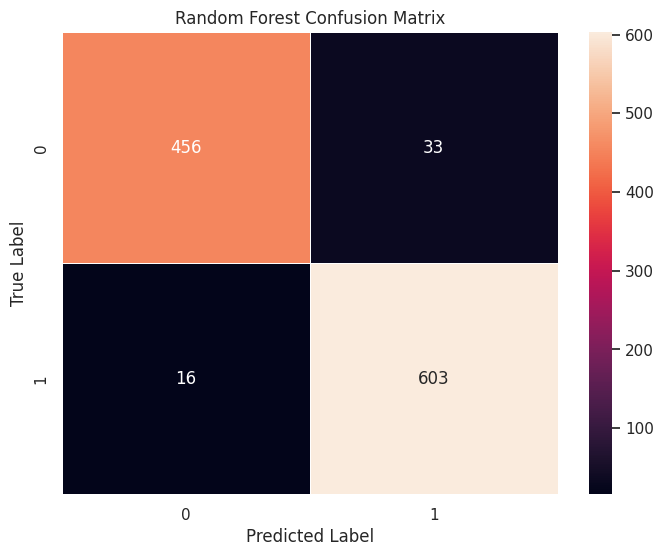

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9774368231046932
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.98      0.97       489
           1       0.98      0.98      0.98       619

    accuracy                           0.98      1108
   macro avg       0.98      0.98      0.98      1108
weighted avg       0.98      0.98      0.98      1108



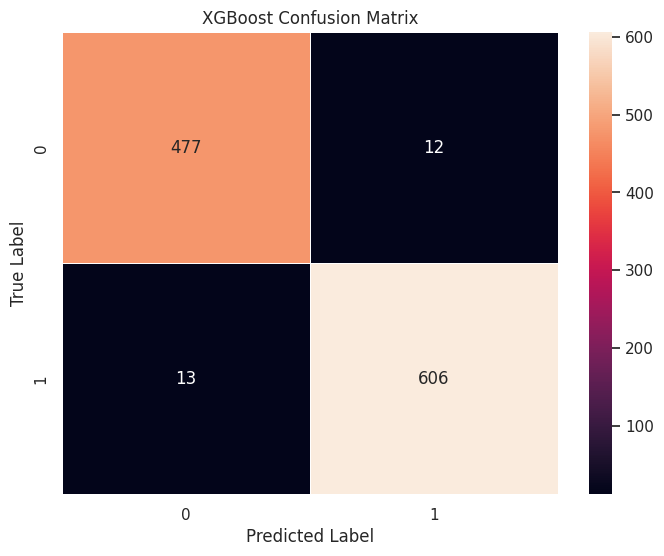

---------------------------------------------------------------------
Decision Tree Classifier Accuracy: 0.8447653429602888
Decision Tree Training Accuracy: 1.0
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.83      0.83       489
           1       0.87      0.85      0.86       619

    accuracy                           0.84      1108
   macro avg       0.84      0.84      0.84      1108
weighted avg       0.85      0.84      0.84      1108



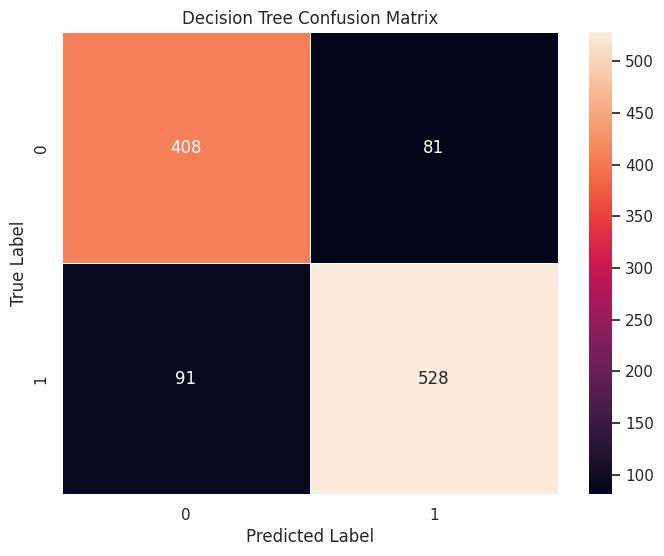

---------------------------------------------------------------------


In [66]:
RF_classifier = RandomForestClassifier(n_estimators=100,random_state=42)
XGB_classifier = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
DT_classifier = DecisionTreeClassifier(random_state=42)


classifier = {
    'Random Forest':RF_classifier,
    'XGBoost':XGB_classifier,
    'Decision Tree':DT_classifier
}
accuracy_tree = evaluate_classifiers(classifier, X_train_tree, y_train_tree, X_test_tree, y_test_tree)

**MLP-NN - with tree based feature selection applied**

In [67]:
X_train_ANN_tree, X_test_ANN_tree, y_train_ANN_tree, y_test_ANN_tree = X_train_tree.copy() , X_test_tree.copy() , y_train_tree.copy() , y_test_tree.copy()
# Scaling
scaler = StandardScaler()
X_train_ANN_tree = scaler.fit_transform(X_train_ANN_tree)
X_test_ANN_tree= scaler.transform(X_test_ANN_tree)

In [68]:
tree_model_ANN = ANN_model(input_shape=[X_train_ANN_tree.shape[1]])

In [69]:
history_ANN_tree = tree_model_ANN.fit(X_train_ANN_tree, y_train_ANN_tree, epochs=20, validation_split = 0.2)

Epoch 1/20
111/111 [==============================] - 1s 5ms/step - loss: 0.5243 - accuracy: 0.7408 - val_loss: 0.3984 - val_accuracy: 0.8523
Epoch 2/20
111/111 [==============================] - 0s 3ms/step - loss: 0.3164 - accuracy: 0.8835 - val_loss: 0.2936 - val_accuracy: 0.8952
Epoch 3/20
111/111 [==============================] - 0s 3ms/step - loss: 0.2214 - accuracy: 0.9230 - val_loss: 0.2437 - val_accuracy: 0.9030
Epoch 4/20
111/111 [==============================] - 0s 3ms/step - loss: 0.1631 - accuracy: 0.9436 - val_loss: 0.2086 - val_accuracy: 0.9200
Epoch 5/20
111/111 [==============================] - 0s 3ms/step - loss: 0.1221 - accuracy: 0.9619 - val_loss: 0.1868 - val_accuracy: 0.9301
Epoch 6/20
111/111 [==============================] - 0s 3ms/step - loss: 0.1030 - accuracy: 0.9681 - val_loss: 0.1807 - val_accuracy: 0.9324
Epoch 7/20
111/111 [==============================] - 0s 3ms/step - loss: 0.0709 - accuracy: 0.9803 - val_loss: 0.1647 - val_accuracy: 0.9335
Epoch 

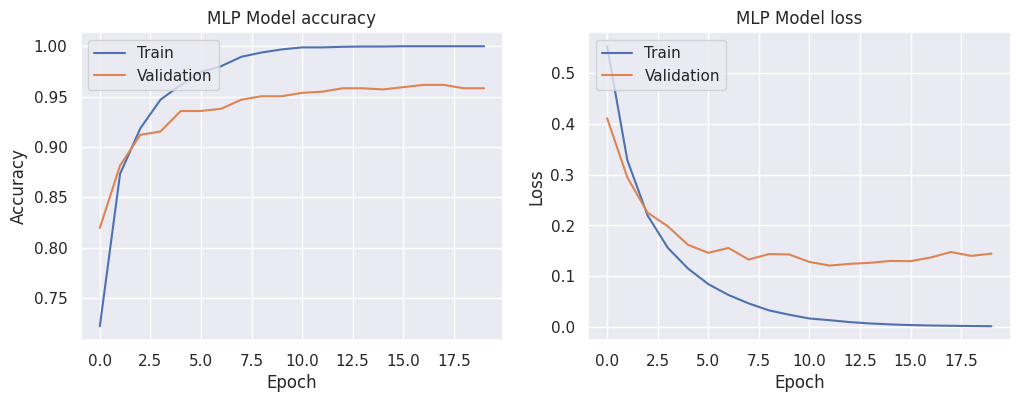

35/35 [==============================] - 0s 2ms/step - loss: 0.1489 - accuracy: 0.9693


[0.14888955652713776, 0.9693140983581543]

In [ ]:
plot_learning_curve(history_ANN_tree)
tree_model_ANN .evaluate(X_test_ANN_tree, y_test_ANN_tree)

**CV ANN**

In [ ]:
# Define the number of splits
n_splits = 10
kf = KFold(n_splits=n_splits, shuffle=True, random_state=19)

# Convert your data to numpy arrays if they are not already
X = X_train_tree.copy().values if hasattr(X_train_tree, 'values') else X_train_tree.copy()
y = y_train_tree.copy().values if hasattr(y_train_tree, 'values') else y_train_tree.copy()


train_accuracies = []
val_accuracies = []

# Cross-validation loop
fold = 1
for train_index, val_index in kf.split(X):
    X_train_fold, X_val_fold = X[train_index], X[val_index]
    y_train_fold, y_val_fold = y[train_index], y[val_index]

    # Scaling the data
    X_train_fold = scaler.fit_transform(X_train_fold)
    X_val_fold = scaler.transform(X_val_fold)

    ANN_CV_model = ANN_model(input_shape=[X_train_fold.shape[1]])
    ANN_CV_history = ANN_CV_model.fit(X_train_fold, y_train_fold, epochs=20, verbose=0)

    # Evaluate the model on the validation set
    val_loss, val_acc = ANN_CV_model.evaluate(X_val_fold, y_val_fold, verbose=0)

    train_acc = ANN_CV_history.history['accuracy'][-1]

    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f'Fold {fold}: Train Accuracy: {train_acc:.4f}, Validation Accuracy: {val_acc:.4f}')

    fold += 1

# Average accuracy across folds
average_train_acc = np.mean(train_accuracies)
average_val_acc = np.mean(val_accuracies)

print(f'Average Training Accuracy: {average_train_acc:.4f}')
print(f'Average Validation Accuracy: {average_val_acc:.4f}')

Fold 1: Train Accuracy: 1.0000, Validation Accuracy: 0.9707
Fold 2: Train Accuracy: 1.0000, Validation Accuracy: 0.9640
Fold 3: Train Accuracy: 1.0000, Validation Accuracy: 0.9549
Fold 4: Train Accuracy: 1.0000, Validation Accuracy: 0.9549
Fold 5: Train Accuracy: 0.9957, Validation Accuracy: 0.9639
Fold 6: Train Accuracy: 1.0000, Validation Accuracy: 0.9616
Fold 7: Train Accuracy: 1.0000, Validation Accuracy: 0.9594
Fold 8: Train Accuracy: 1.0000, Validation Accuracy: 0.9752
Fold 9: Train Accuracy: 1.0000, Validation Accuracy: 0.9616
Fold 10: Train Accuracy: 1.0000, Validation Accuracy: 0.9616
Average Training Accuracy: 0.9996
Average Validation Accuracy: 0.9628


**Machine Learning Model Cross Validation**

In [ ]:
def evaluate_cross_val_score(models, X_train, y_train, results, cv=10, scoring='accuracy'):
    """
    Evaluate models performance using cross-validation.

    """
    for model_name, model in models.items():
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        results[model_name] = scores.mean()

    return results

results = {}

models_1 = {
    'Random Forest':RF_classifier,
    'XGBoost':XGB_classifier,
    'Decision Tree':DT_classifier
}

# Run Function
results = evaluate_cross_val_score(models_1, X_train_tree, y_train_tree, results)

# Print results
for model_name, score in results.items():
    print(f"{model_name}: {score}")

Random Forest: 0.9444959632318548
XGBoost: 0.965030097817908
Decision Tree: 0.821751774347711


**HYPERPARAMETER TUNING**

In [ ]:
def evaluate_model_with_gridsearch(model, param_grid, X, y):
    """
    Performs GridSearchCV on the given model and parameter grid, plots training and testing scores

    """
    # Perform grid search
    GS = GridSearchCV(model, param_grid, cv=10, return_train_score=True, n_jobs=-1)
    GS.fit(X, y)

    # Best parameters and estimator
    print("Best Parameters:", GS.best_params_)
    print(f"Test Accuracy Score for Best Parameters: {GS.best_score_:.4f}")

    # Extract train and test accuracy scores
    train_accuracy_scores = GS.cv_results_['mean_train_score']
    test_accuracy_scores = GS.cv_results_['mean_test_score']

    # Generate the parameter value labels
    param_keys = list(param_grid.keys())
    param_values = [str(d[param_keys[0]]) for d in GS.cv_results_['params']]


    plt.figure(figsize=(12, 6))
    plt.plot(param_values, train_accuracy_scores, marker='o', linestyle='-', color='r', label='Training Score')
    plt.plot(param_values, test_accuracy_scores, marker='o', linestyle='-', color='b', label='Testing Score')
    plt.xlabel(param_keys[0],fontsize = 15)
    plt.ylabel('Accuracy Score',fontsize = 15)
    plt.title(f'Training vs. Testing Performance of {model.__class__.__name__} with Different Parameters', size = 18)
    plt.legend()
    plt.grid(True)
    plt.show()

%%time
param_RF = {
    'max_depth': [3,5,7,10],
    'n_estimators': [100, 200, 300, 400, 500],
    'max_features': [10, 20, 30 , 40],
    'min_samples_leaf': [1, 2, 4]
}

evaluate_model_with_gridsearch(RF_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'max_depth': 26}
Test Accuracy Score for Best Parameters: 0.9551


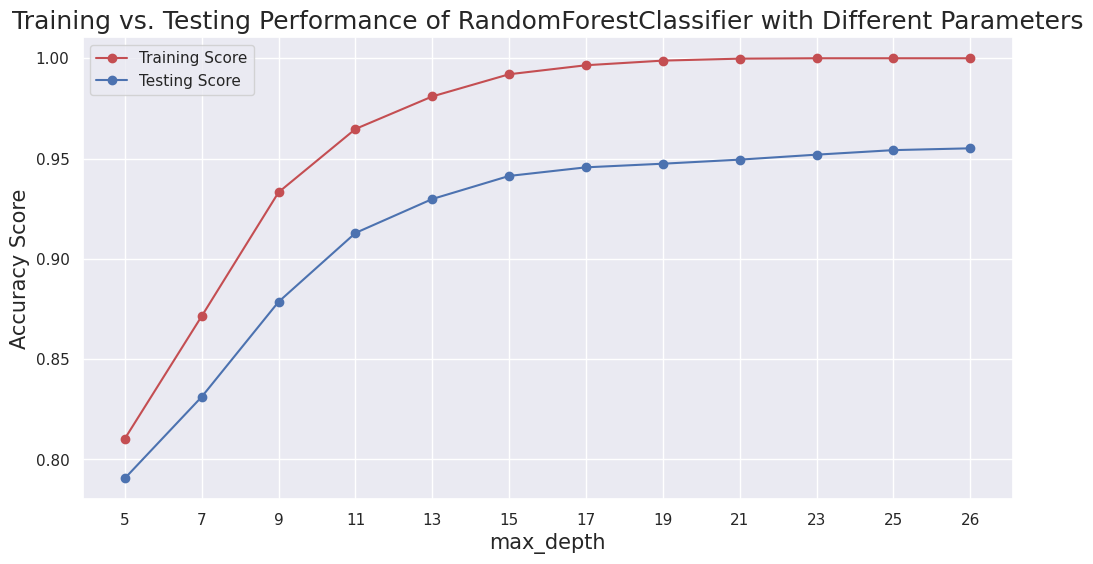

CPU times: user 10.9 s, sys: 717 ms, total: 11.6 s
Wall time: 7min 21s


In [ ]:
%%time
param_RF = {
    'max_depth': [3, 5, 7, 9],
}
RF_classifier = RandomForestClassifier(random_state=19)
evaluate_model_with_gridsearch(RF_classifier, param_RF, X_train_tree, y_train_tree)

Best Parameters: {'n_estimators': 100}
Test Accuracy Score for Best Parameters: 0.9571


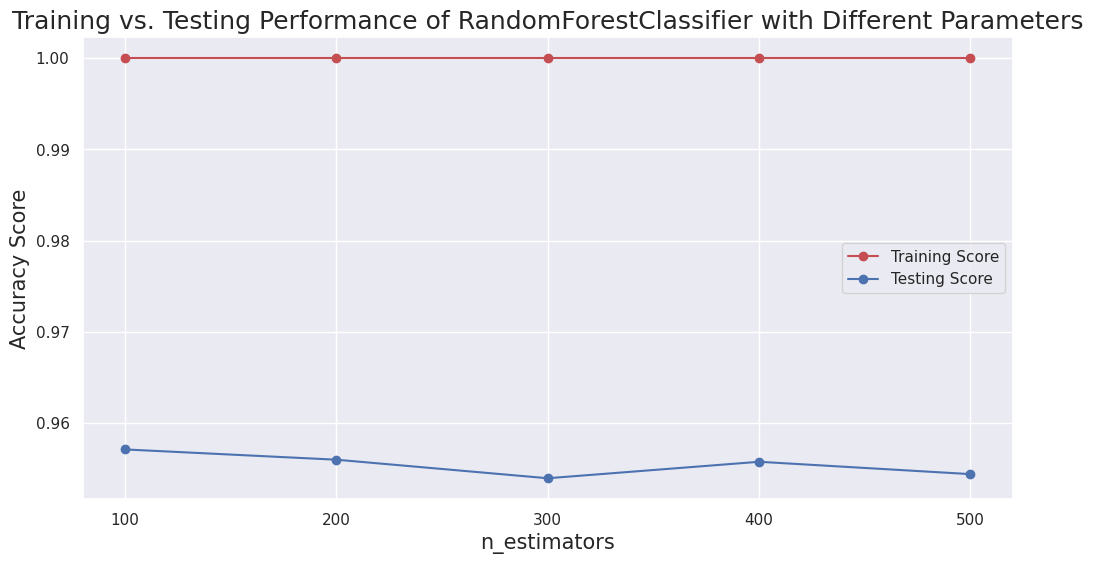

CPU times: user 11.7 s, sys: 918 ms, total: 12.7 s
Wall time: 11min 11s


In [ ]:
%%time
param_RF = {
    'n_estimators': [100, 200, 300, 400, 500],
}

evaluate_model_with_gridsearch(RF_classifier, param_RF, X_train_tree, y_train_tree)

Best Parameters: {'max_features': 30}
Test Accuracy Score for Best Parameters: 0.9574


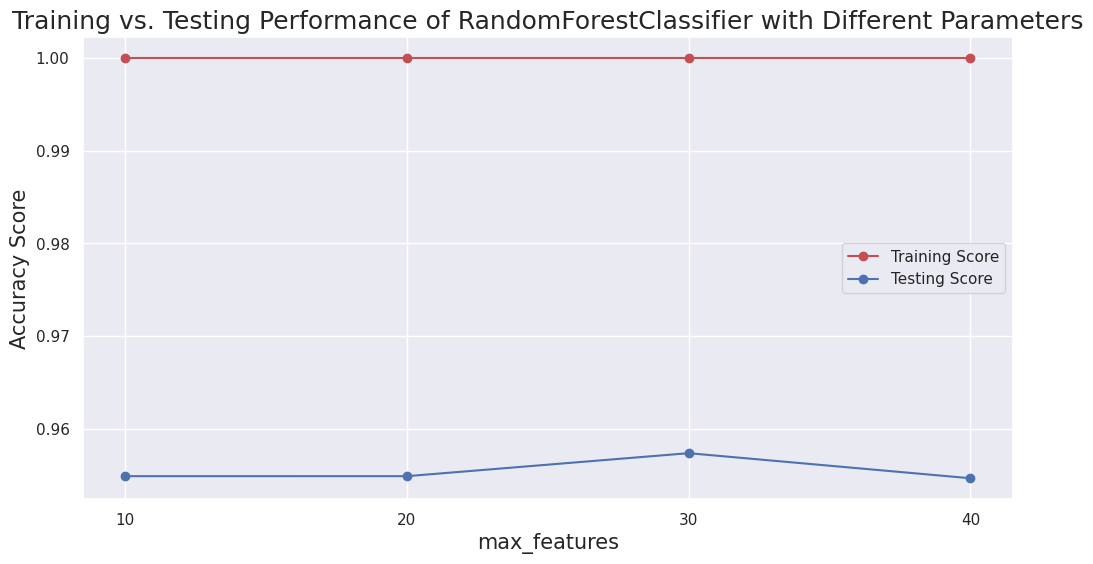

CPU times: user 20.8 s, sys: 686 ms, total: 21.5 s
Wall time: 7min 7s


In [ ]:
%%time
param_RF = {
    'max_features': [10, 20, 30 , 40],

}

evaluate_model_with_gridsearch(RF_classifier, param_RF, X_train_tree, y_train_tree)

Best Parameters: {'min_samples_leaf': 1}
Test Accuracy Score for Best Parameters: 0.9571


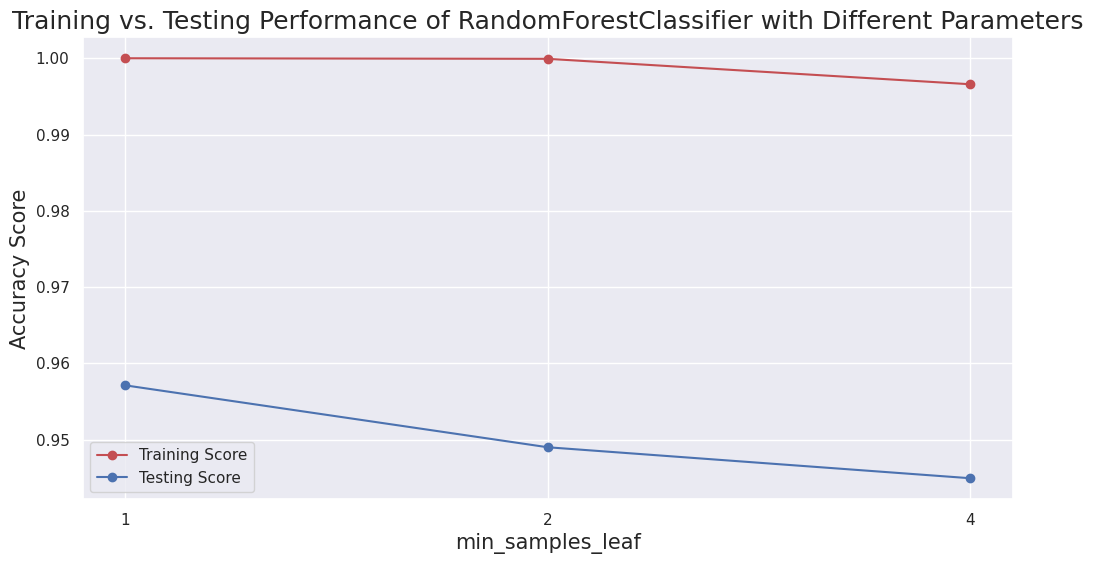

CPU times: user 7.37 s, sys: 217 ms, total: 7.59 s
Wall time: 2min 14s


In [ ]:
%%time
param_RF = {
    'min_samples_leaf': [1, 2, 4]
}

evaluate_model_with_gridsearch(RF_classifier, param_RF, X_train_tree, y_train_tree)

%%time
param_XGB ={
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'min_child_weight': 1}
Test Accuracy Score for Best Parameters: 0.9691


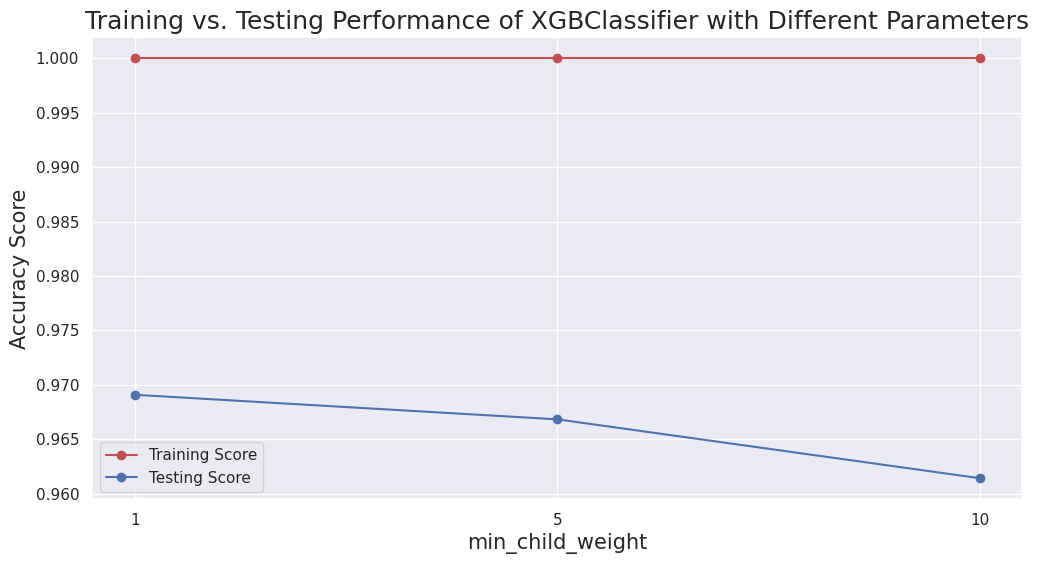

CPU times: user 9.38 s, sys: 146 ms, total: 9.52 s
Wall time: 57.8 s


In [ ]:
%%time
param_XGB ={
        'min_child_weight': [1, 5, 10],
        }

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'gamma': 0.5}
Test Accuracy Score for Best Parameters: 0.9657


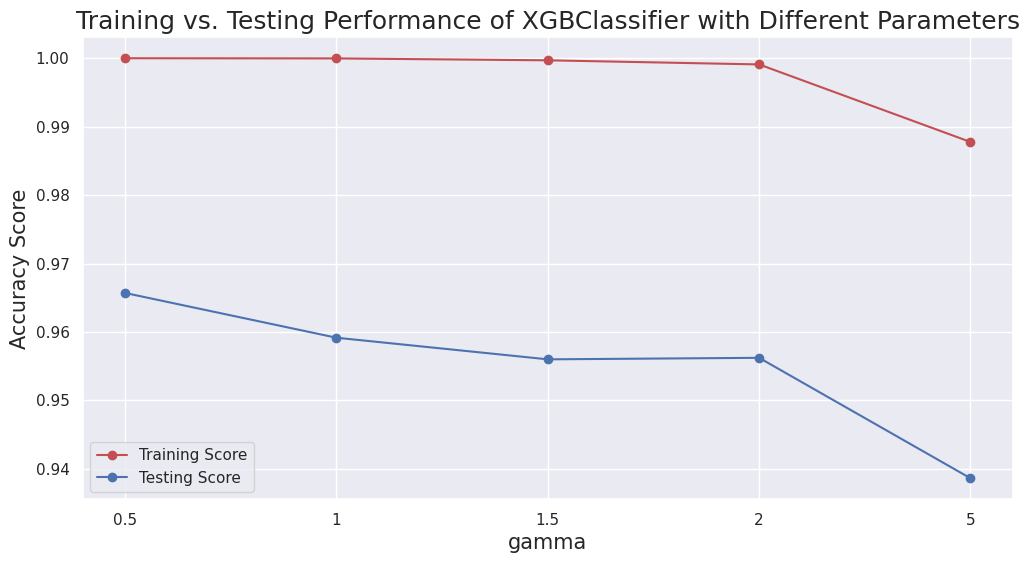

CPU times: user 4.34 s, sys: 232 ms, total: 4.57 s
Wall time: 1min 10s


In [ ]:
%%time
param_XGB ={
        'gamma': [0.5, 1, 1.5, 2, 5],
        }

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'subsample': 1.0}
Test Accuracy Score for Best Parameters: 0.9691


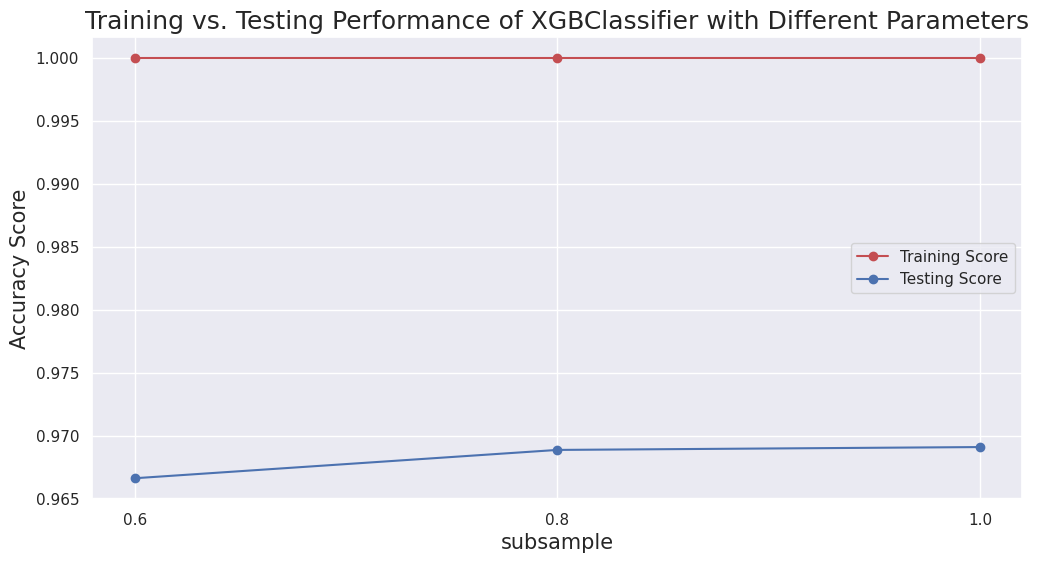

CPU times: user 5.59 s, sys: 234 ms, total: 5.82 s
Wall time: 1min 12s


In [ ]:
%%time
param_XGB ={
        'subsample': [0.6, 0.8, 1.0],
        }

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'colsample_bytree': 0.8}
Test Accuracy Score for Best Parameters: 0.9727


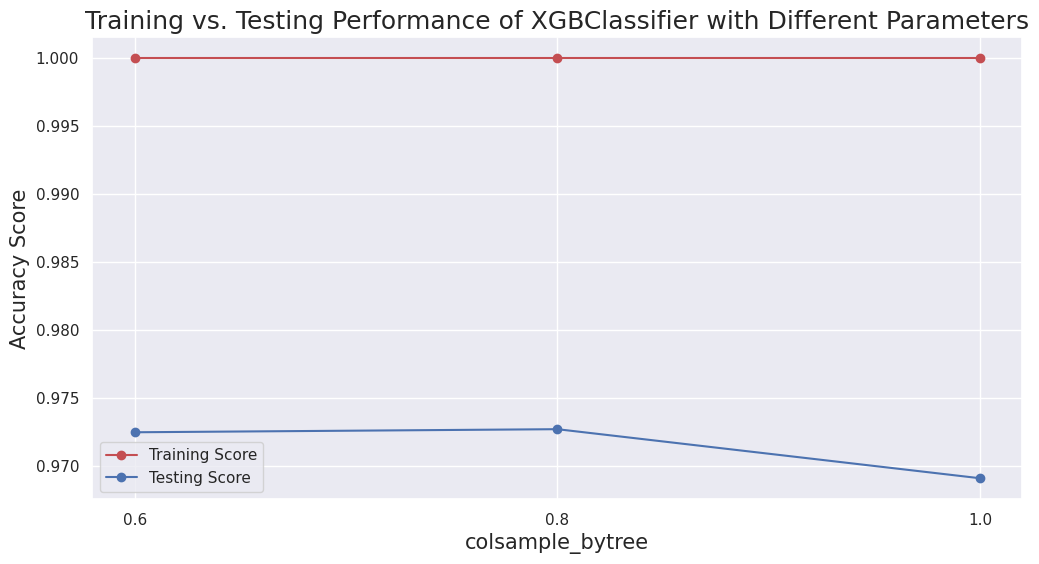

CPU times: user 4.9 s, sys: 184 ms, total: 5.08 s
Wall time: 1min 5s


In [ ]:
%%time
param_XGB ={
        'colsample_bytree': [0.6, 0.8, 1.0],
}

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

Best Parameters: {'max_depth': 7}
Test Accuracy Score for Best Parameters: 0.9732


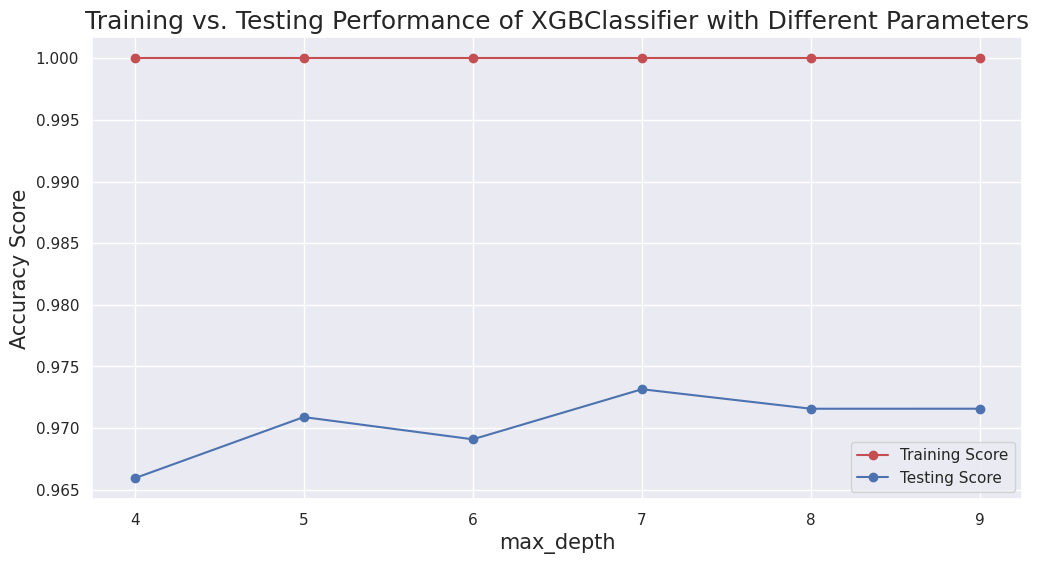

CPU times: user 10.5 s, sys: 385 ms, total: 10.9 s
Wall time: 2min 29s


In [ ]:
%%time
param_XGB ={
        'max_depth': [ 4, 5, 6, 7, 8, 9]
        }

evaluate_model_with_gridsearch(XGB_classifier, param_XGB, X_train_tree, y_train_tree)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Best Parameters: {'criterion': 'entropy'}
Test Accuracy Score for Best Parameters: 0.8319


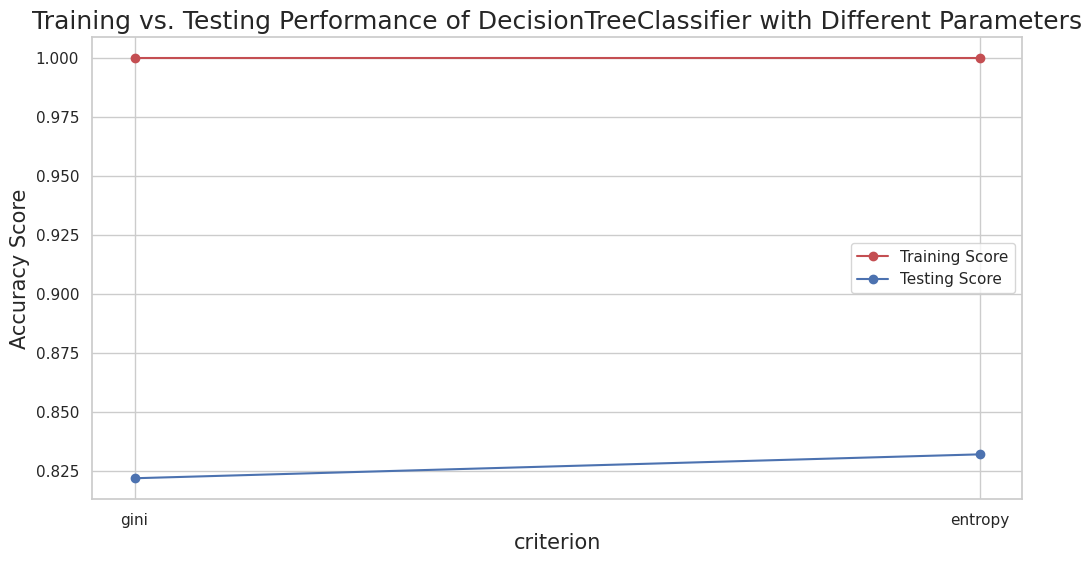

CPU times: user 7.08 s, sys: 517 ms, total: 7.6 s
Wall time: 2min 36s


In [ ]:
%%time
param_DT ={
        'criterion': ['gini', 'entropy']
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

Best Parameters: {'splitter': 'random'}
Test Accuracy Score for Best Parameters: 0.8224


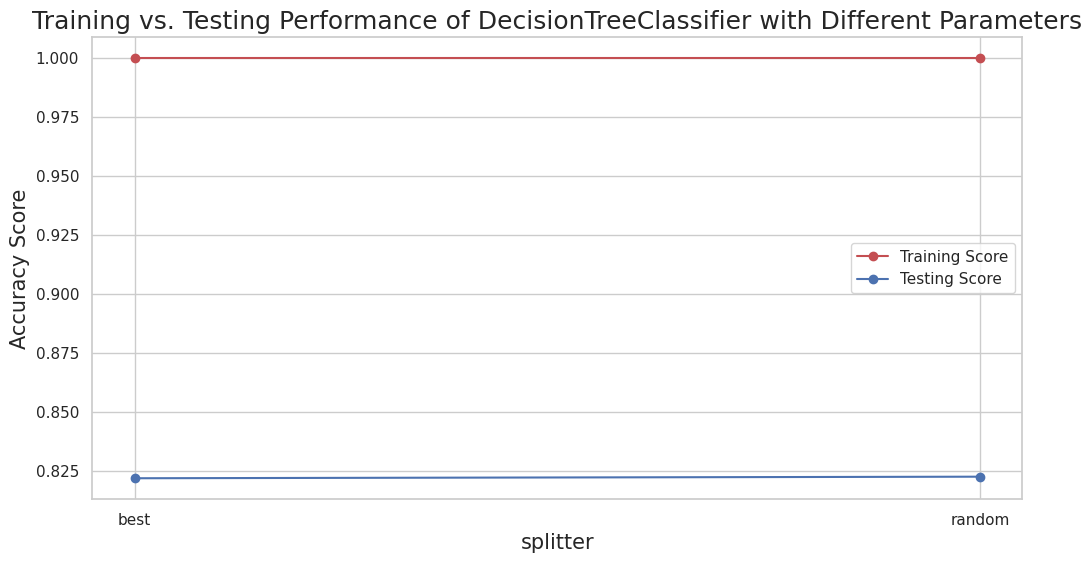

CPU times: user 1.16 s, sys: 208 ms, total: 1.37 s
Wall time: 51.9 s


In [ ]:
%%time
param_DT ={
        'splitter': ['best', 'random']
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

Best Parameters: {'max_depth': 20}
Test Accuracy Score for Best Parameters: 0.8227


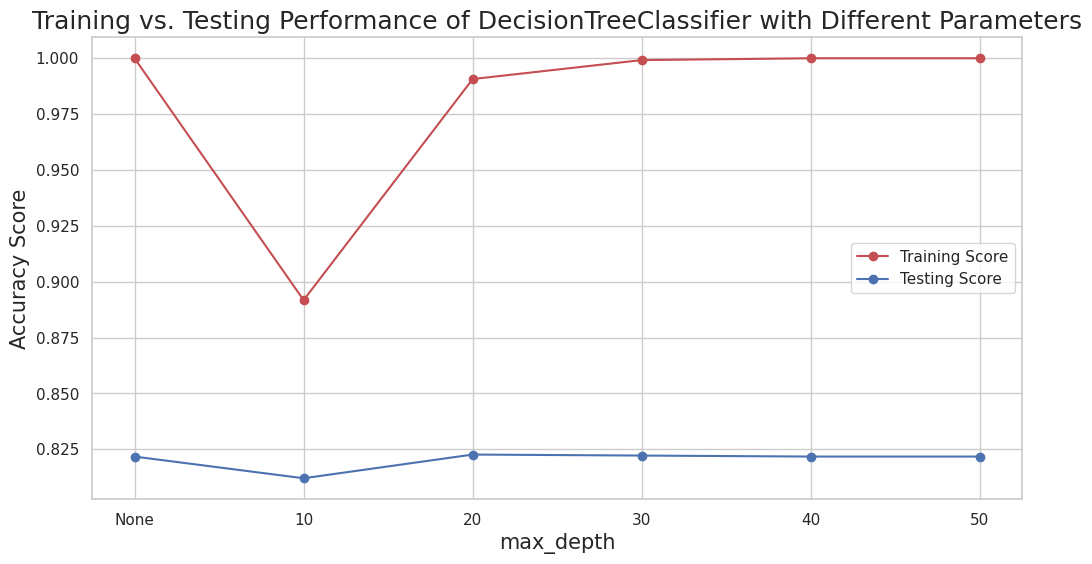

CPU times: user 8.94 s, sys: 559 ms, total: 9.5 s
Wall time: 4min 18s


In [ ]:
%%time
param_DT ={
        'max_depth': [None, 10, 20, 30, 40, 50]
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

Best Parameters: {'min_samples_split': 5}
Test Accuracy Score for Best Parameters: 0.8231


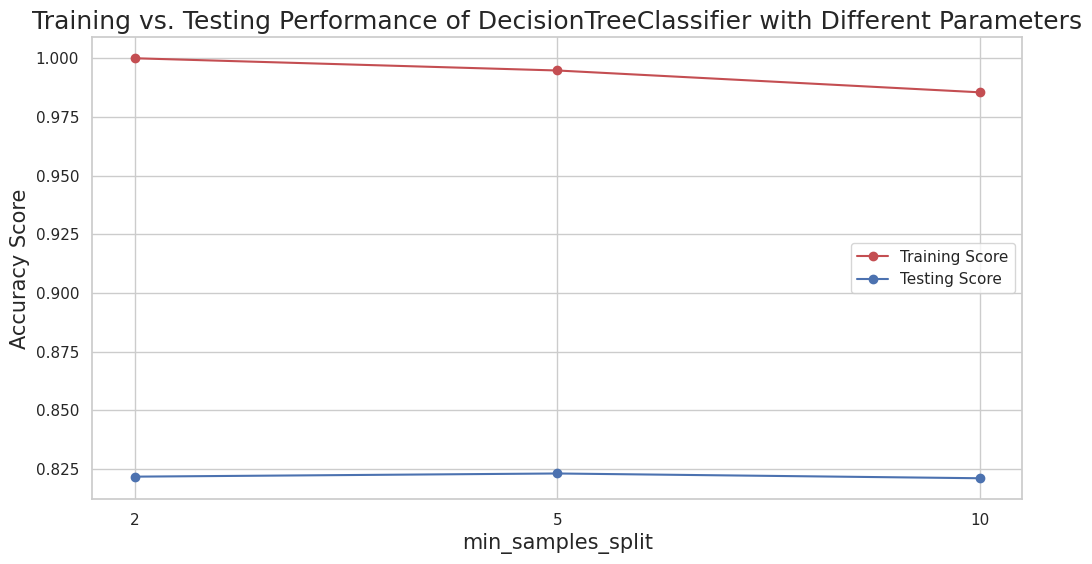

CPU times: user 7.8 s, sys: 277 ms, total: 8.07 s
Wall time: 2min


In [ ]:
%%time
param_DT ={
        'min_samples_split': [2, 5, 10]
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

Best Parameters: {'min_samples_leaf': 4}
Test Accuracy Score for Best Parameters: 0.8258


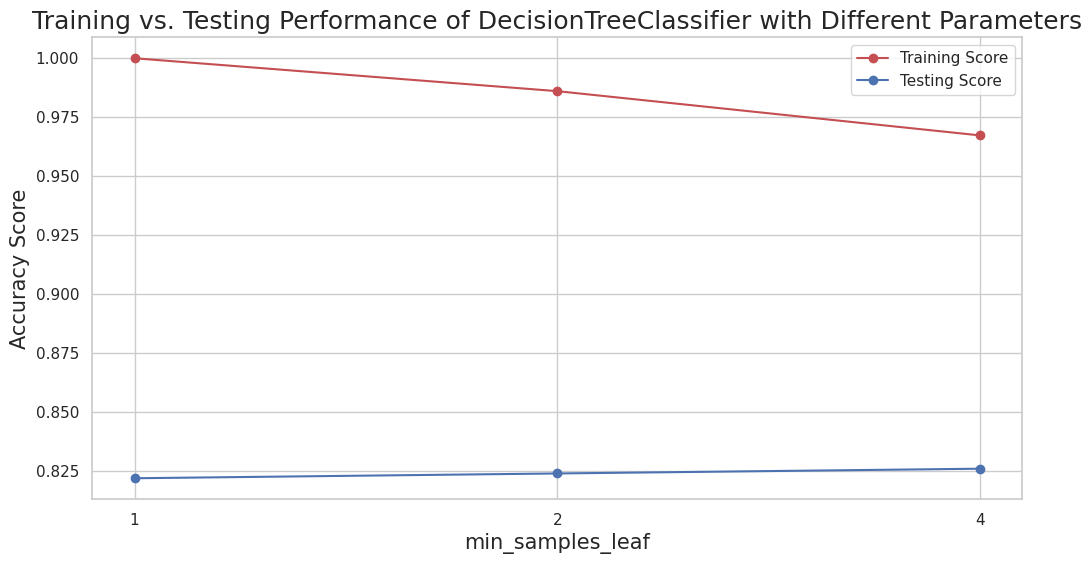

CPU times: user 6.89 s, sys: 311 ms, total: 7.2 s
Wall time: 1min 52s


In [ ]:
%%time
param_DT ={
        'min_samples_leaf': [1, 2, 4]
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
10 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 638, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/_

Best Parameters: {'max_features': None}
Test Accuracy Score for Best Parameters: 0.8218


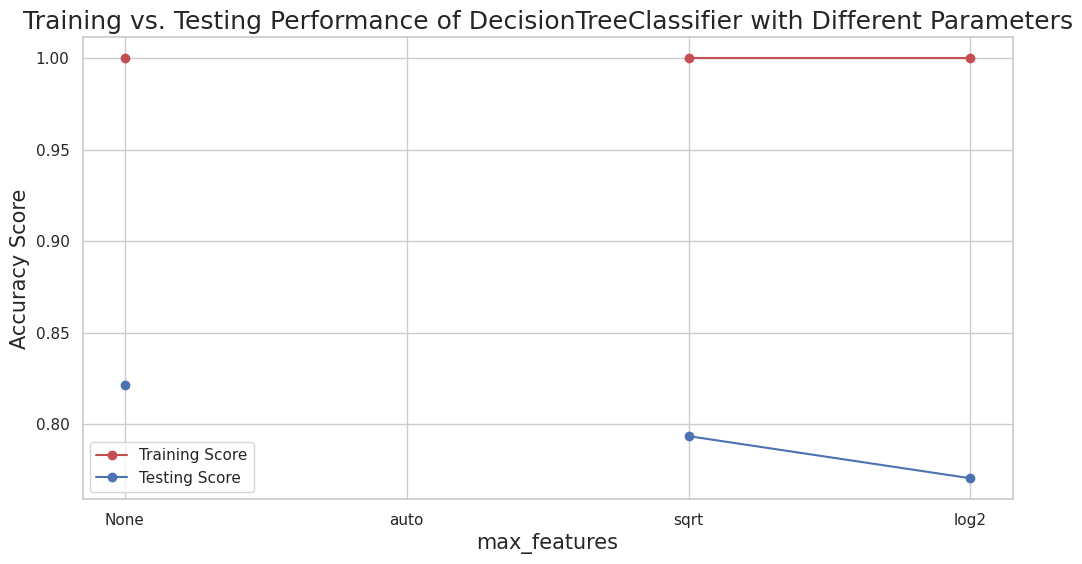

CPU times: user 7.16 s, sys: 142 ms, total: 7.3 s
Wall time: 46.5 s


In [ ]:
%%time
param_DT ={
        'max_features': [None, 'auto', 'sqrt', 'log2']
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

Best Parameters: {'class_weight': 'balanced'}
Test Accuracy Score for Best Parameters: 0.8236


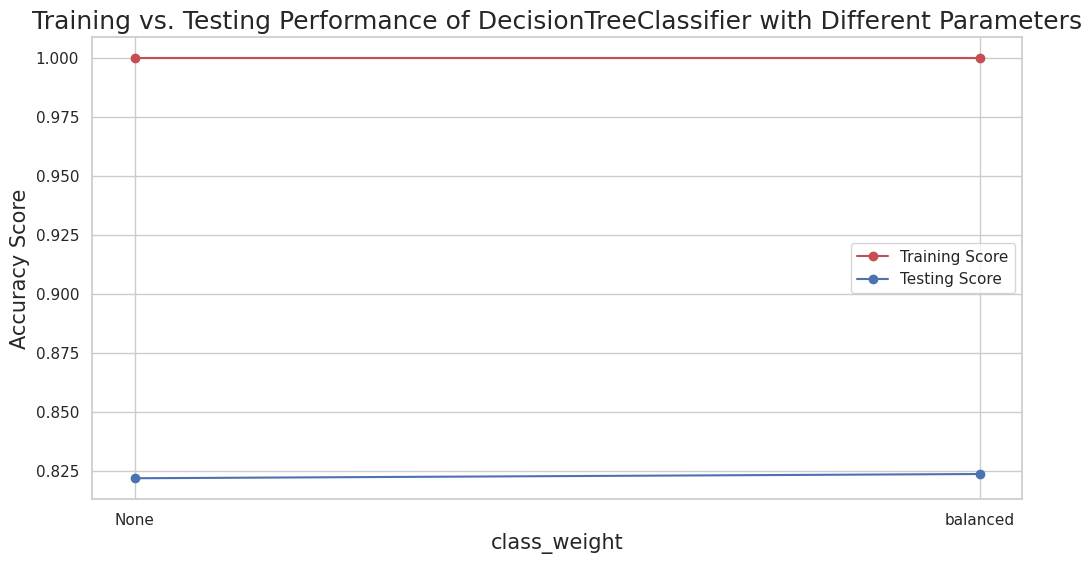

CPU times: user 7.81 s, sys: 229 ms, total: 8.04 s
Wall time: 1min 40s


In [ ]:
%%time
param_DT ={
        'class_weight': [None, 'balanced']
        }

evaluate_model_with_gridsearch(DT_classifier, param_DT, X_train_tree, y_train_tree)

In [ ]:
param_grid = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': [None, 'balanced']
}


**Final Model applied optimal parameter Training & Testing**

Random Forest Classifier Accuracy: 0.9693140794223827
Random Forest Training Accuracy: 1.0
Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.95      0.96       489
           1       0.96      0.98      0.97       619

    accuracy                           0.97      1108
   macro avg       0.97      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108



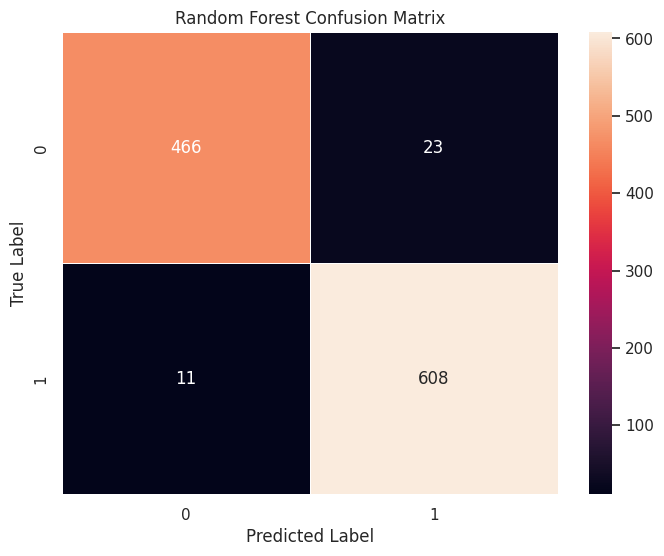

---------------------------------------------------------------------
XGBoost Classifier Accuracy: 0.9711191335740073
XGBoost Training Accuracy: 1.0
XGBoost Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.96      0.97       489
           1       0.97      0.98      0.97       619

    accuracy                           0.97      1108
   macro avg       0.97      0.97      0.97      1108
weighted avg       0.97      0.97      0.97      1108



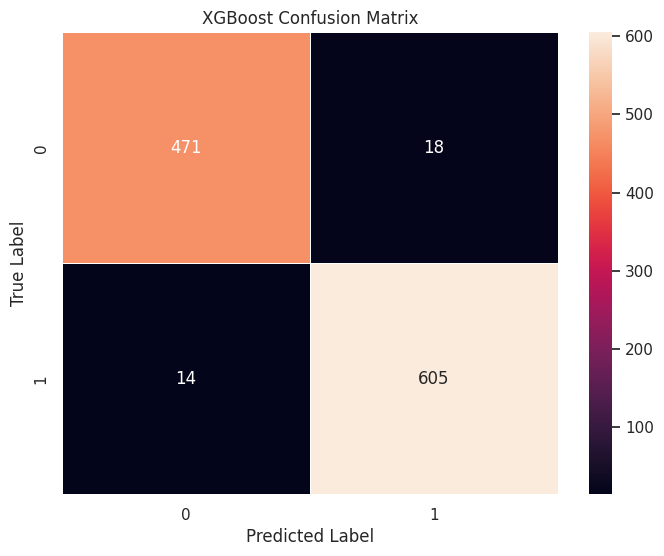

---------------------------------------------------------------------
Decision Tree Classifier Accuracy: 0.825812274368231
Decision Tree Training Accuracy: 0.9221570397111913
Decision Tree Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.82      0.81       489
           1       0.85      0.83      0.84       619

    accuracy                           0.83      1108
   macro avg       0.82      0.82      0.82      1108
weighted avg       0.83      0.83      0.83      1108



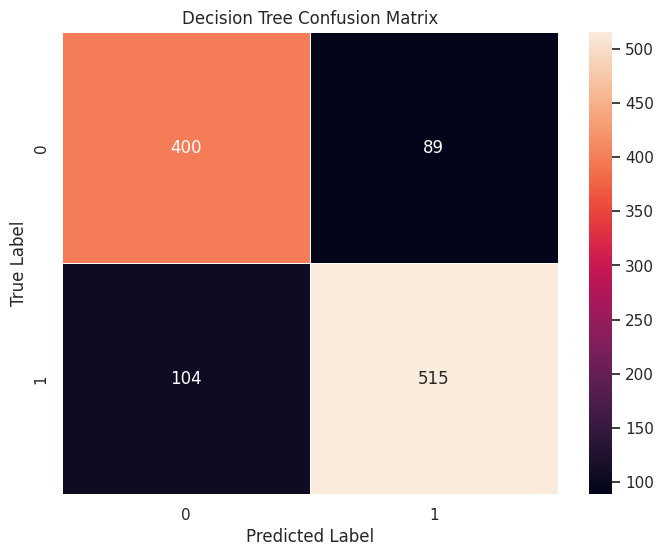

---------------------------------------------------------------------


In [70]:
X_train_final, X_test_final, y_train_final, y_test_final = X_train_tree.copy() , X_test_tree.copy() , y_train_tree.copy() , y_test_tree.copy()

RF_classifier = RandomForestClassifier(max_features = 30, min_samples_leaf = 1, n_estimators=100,random_state=19)
XGB_classifier = xgb.XGBClassifier(min_child_weight = 1, gamma = 0.5, subsample = 1,
                                   colsample_bytree = 0.8,  objective="binary:logistic", random_state=19)
DT_classifier = DecisionTreeClassifier(criterion = 'entropy',splitter = 'random',class_weight = 'balanced',
                                       min_samples_leaf= 4,max_depth = 20, min_samples_split= 5, random_state=19)

classifiers = {
    'Random Forest':RF_classifier,
    'XGBoost':XGB_classifier,
    'Decision Tree':DT_classifier
}
accuracy_tree = evaluate_classifiers(classifiers, X_train_final, y_train_final, X_test_final, y_test_final)

**MLP Hyperparameter Tuning**

In [77]:
X_train_ANN_tree, X_test_ANN_tree, y_train_ANN_tree, y_test_ANN_tree = X_train_tree.copy() , X_test_tree.copy() , y_train_tree.copy() , y_test_tree.copy()
# Scaling
scaler = StandardScaler()
X_train_ANN_tree = scaler.fit_transform(X_train_ANN_tree)
X_test_ANN_tree= scaler.transform(X_test_ANN_tree)

def ANN_GS_model(hp):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape=[137]))
    model.add(layers.Dense(units=hp.Int('units1', min_value=32, max_value=128, step=32), activation=hp.Choice('activation1', ['relu', 'tanh'])))
    model.add(layers.Dense(units=hp.Int('units2', min_value=32, max_value=128, step=32), activation=hp.Choice('activation2', ['relu', 'tanh'])))
    model.add(layers.Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[0.001, 0.01]))

    model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return model


hp = HyperParameters()


tuner = GridSearch(
    ANN_GS_model,
    objective='val_accuracy',
    max_trials=16,  # Total combinations of hyperparameters
    executions_per_trial=3,  # Number of models to build and fit for each trial
    directory='my_dir',
    project_name='grid_search'
)



tuner.search(X_train_ANN_tree , y_train_ANN_tree , epochs=20, validation_data=(X_test_ANN_tree, y_test_ANN_tree), verbose=1)
MLP_HT_best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
MLP_HT_best_model = tuner.hypermodel.build(MLP_HT_best_hps)


MLP_HT_history = MLP_HT_best_model.fit(X_train_ANN_tree , y_train_ANN_tree, epochs=20, validation_data=(X_test_ANN_tree, y_test_ANN_tree), verbose=1)


MLP_HT_test_loss, MLP_HT_test_accuracy = MLP_HT_best_model.evaluate(X_test_ANN_tree, y_test_ANN_tree)
print(f'Test Accuracy: {MLP_HT_test_accuracy:.4f}')
print(f'Best Hyperparameters: {MLP_HT_best_hps.values}')



Trial 16 Complete [00h 00m 58s]
val_accuracy: 0.970818281173706

Best val_accuracy So Far: 0.9798435568809509
Total elapsed time: 00h 13m 24s


NameError: name 'best_hps' is not defined

In [78]:
MLP_HT_best_model = tuner.hypermodel.build(MLP_HT_best_hps)


MLP_HT_history = MLP_HT_best_model.fit(X_train_ANN_tree , y_train_ANN_tree, epochs=20, validation_data=(X_test_ANN_tree, y_test_ANN_tree), verbose=1)


MLP_HT_test_loss, MLP_HT_test_accuracy = MLP_HT_best_model.evaluate(X_test_ANN_tree, y_test_ANN_tree)
print(f'Test Accuracy: {MLP_HT_test_accuracy:.4f}')
print(f'Best Hyperparameters: {MLP_HT_best_hps.values}')

Epoch 1/20
139/139 [==============================] - 6s 16ms/step - loss: 0.3845 - accuracy: 0.8366 - val_loss: 0.2628 - val_accuracy: 0.8926
Epoch 2/20
139/139 [==============================] - 1s 11ms/step - loss: 0.1830 - accuracy: 0.9316 - val_loss: 0.1817 - val_accuracy: 0.9269
Epoch 3/20
139/139 [==============================] - 2s 12ms/step - loss: 0.1216 - accuracy: 0.9576 - val_loss: 0.2047 - val_accuracy: 0.9269
Epoch 4/20
139/139 [==============================] - 2s 15ms/step - loss: 0.0819 - accuracy: 0.9662 - val_loss: 0.1449 - val_accuracy: 0.9513
Epoch 5/20
139/139 [==============================] - 1s 5ms/step - loss: 0.1170 - accuracy: 0.9709 - val_loss: 0.2181 - val_accuracy: 0.9359
Epoch 6/20
139/139 [==============================] - 1s 5ms/step - loss: 0.1007 - accuracy: 0.9682 - val_loss: 0.1534 - val_accuracy: 0.9549
Epoch 7/20
139/139 [==============================] - 1s 5ms/step - loss: 0.0634 - accuracy: 0.9806 - val_loss: 0.1389 - val_accuracy: 0.9693
Ep

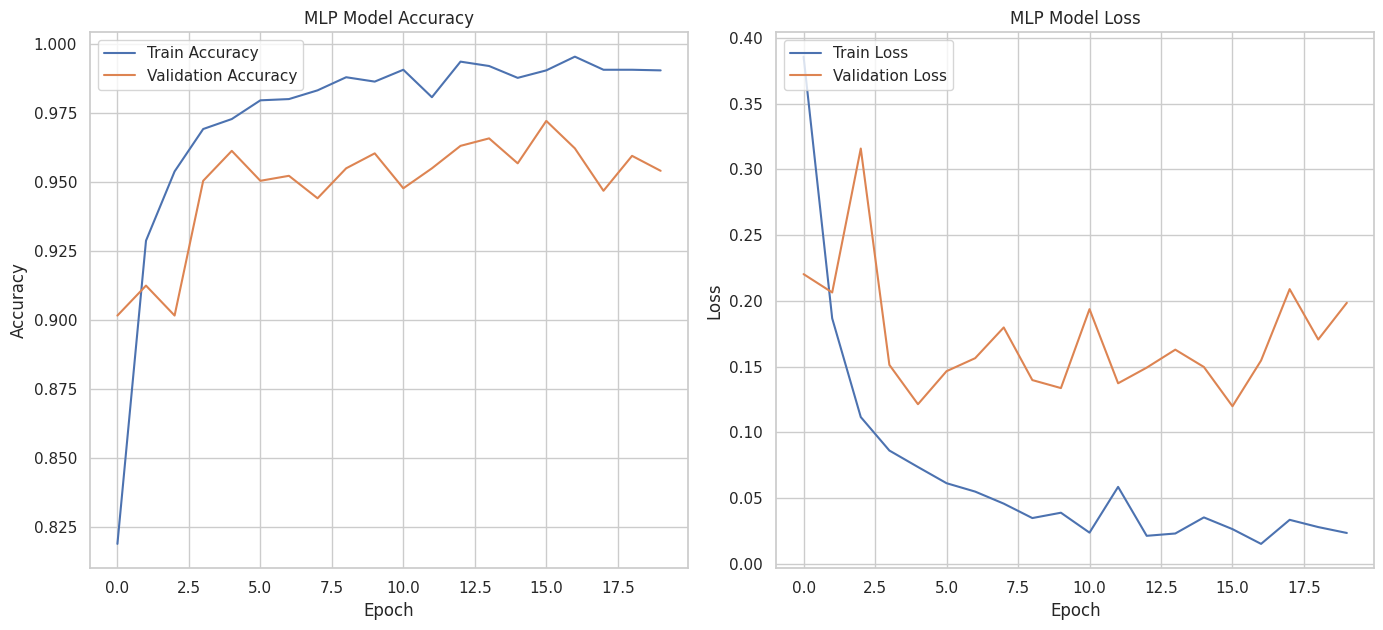

In [ ]:
def plot_training_history(history):
    plt.figure(figsize=(14, 12))

    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('MLP Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')


    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('MLP Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')

    plt.tight_layout()
    plt.show()

plot_training_history(history)


35/35 [==============================] - 0s 5ms/step


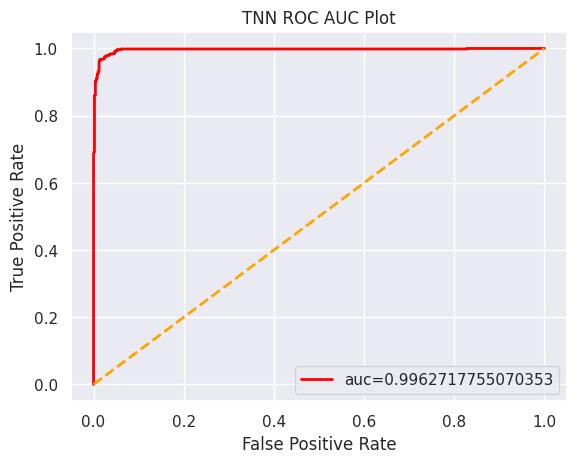

In [81]:
MLP_HT_y_pred = MLP_HT_best_model.predict(X_test_ANN_tree)
MLP_HT_fpr, MLP_HT_tpr, _ = roc_curve(y_test_ANN_tree,  MLP_HT_y_pred)
MLP_HT_auc = roc_auc_score(y_test_ANN_tree, MLP_HT_y_pred)
plt.plot(MLP_HT_fpr,MLP_HT_tpr,label="auc="+str(MLP_HT_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()


**TNN Hyperparameter tuning**

In [ ]:
def TNN_GS_model(hp):
    embed_dim = 32
    num_heads = 2
    ff_dim = hp.Int('ff_dim', min_value=32, max_value=128, step=32)
    rate = hp.Float('rate', min_value=0.1, max_value=0.5, step=0.1)

    if embed_dim % num_heads != 0:
        raise ValueError(
            f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
        )

    inputs = layers.Input(shape=(512, 19))
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim, rate)
    transformer_block2 = TransformerBlock(embed_dim, num_heads, ff_dim, rate)
    x = transformer_block(x, training=True)
    x = transformer_block2(x, training=True)

    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dropout(rate)(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    model = keras.Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2]))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    TNN_GS_model,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='transformer_hyperparam_tuning'
)

In [ ]:
X_train_TNN_GS, X_test_TNN_GS, y_train_TNN_GS, y_test_TNN_GS = train_test_split(X_NN, y_NN, test_size=0.20, random_state=19)

In [ ]:
tuner.search(X_train_TNN_GS, y_train_TNN_GS, epochs=10, validation_data=(X_test_TNN_GS, y_test_TNN_GS), verbose=1)

Trial 5 Complete [00h 54m 34s]
val_accuracy: 0.9828519821166992

Best val_accuracy So Far: 0.9828519821166992
Total elapsed time: 05h 47m 34s

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
32                |128               |ff_dim
0.5               |0.1               |rate
0.0001            |0.001             |learning_rate

Epoch 1/10
139/139 [==============================] - 157s 1s/step - loss: 0.6770 - accuracy: 0.5783 - val_loss: 0.6337 - val_accuracy: 0.6543
Epoch 2/10
139/139 [==============================] - 149s 1s/step - loss: 0.6139 - accuracy: 0.6792 - val_loss: 0.5470 - val_accuracy: 0.7437
Epoch 3/10
139/139 [==============================] - 156s 1s/step - loss: 0.5456 - accuracy: 0.7407 - val_loss: 0.4756 - val_accuracy: 0.7798
Epoch 4/10
139/139 [==============================] - 158s 1s/step - loss: 0.4912 - accuracy: 0.7676 - val_loss: 0.4279 - val_accuracy: 0.8042
Epoch 5/10
139/139 [==============================] - 159s 1s/ste

In [71]:
def TNN_model():

    num_classes = 1
    activation_fn = 'sigmoid'

    inputs = layers.Input(shape=(512, 19))

    # Conv1D layer to initially process each channel
    x = layers.Conv1D(filters=32, kernel_size=3, activation='relu', padding='same')(inputs)
    x = layers.BatchNormalization()(x)

    # Transformer Block
    transformer_block = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=128)
    transformer_block2 = TransformerBlock(embed_dim=32, num_heads=2, ff_dim=128)
    x = transformer_block(x, training=True)
    x = transformer_block2(x, training=True)

    # Pooling layer to reduce dimensionality
    x = layers.GlobalAveragePooling1D()(x)

    # Dropout for regularization
    x = layers.Dropout(0.5)(x)

    # Dense layer for classification
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation=activation_fn)(x)

    optimizer = Adam(clipvalue=0.5, learning_rate=0.001)
    model = models.Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy', metrics=['accuracy'])

    return model

In [72]:
# Build and train the final model on the full training data
TNN_final_model = TNN_model()
TNN_final_history = TNN_final_model.fit(X_train_NN, y_train_NN, epochs=15, batch_size=16, validation_split=0.2)

# Evaluate the final model on the test data
test_loss_tnn, test_accuracy_tnn = TNN_final_model.evaluate(X_test_NN, y_test_NN)
print(f'TNN Test Accuracy: {test_accuracy_tnn:.4f}')


Epoch 1/15
222/222 [==============================] - 252s 1s/step - loss: 0.5042 - accuracy: 0.7504 - val_loss: 0.3554 - val_accuracy: 0.8523
Epoch 2/15
222/222 [==============================] - 149s 670ms/step - loss: 0.3189 - accuracy: 0.8683 - val_loss: 0.2494 - val_accuracy: 0.9132
Epoch 3/15
222/222 [==============================] - 125s 561ms/step - loss: 0.2594 - accuracy: 0.8948 - val_loss: 0.2353 - val_accuracy: 0.8952
Epoch 4/15
222/222 [==============================] - 121s 546ms/step - loss: 0.1966 - accuracy: 0.9306 - val_loss: 0.2080 - val_accuracy: 0.9188
Epoch 5/15
222/222 [==============================] - 123s 553ms/step - loss: 0.1605 - accuracy: 0.9405 - val_loss: 0.1603 - val_accuracy: 0.9301
Epoch 6/15
222/222 [==============================] - 132s 594ms/step - loss: 0.1476 - accuracy: 0.9472 - val_loss: 0.1217 - val_accuracy: 0.9504
Epoch 7/15
222/222 [==============================] - 120s 540ms/step - loss: 0.1436 - accuracy: 0.9441 - val_loss: 0.1595 - va

35/35 [==============================] - 16s 421ms/step


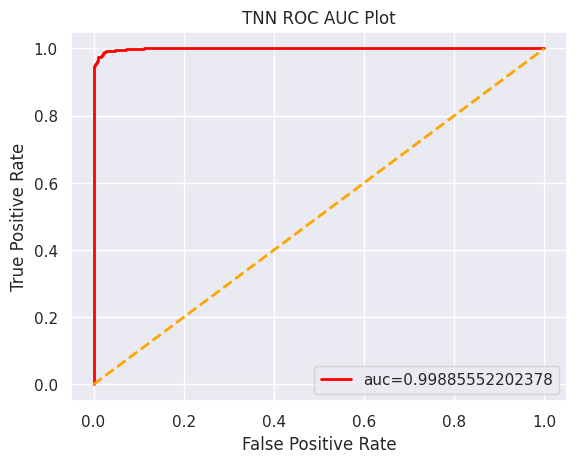

In [73]:
TNN_HT_y_pred = TNN_final_model.predict(X_test_NN)
TNN_HT_fpr, TNN_HT_tpr, _ = roc_curve(y_test_NN,  TNN_HT_y_pred)
TNN_HT_auc = roc_auc_score(y_test_NN, TNN_HT_y_pred)
plt.plot(TNN_HT_fpr,TNN_HT_tpr,label="auc="+str(TNN_HT_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

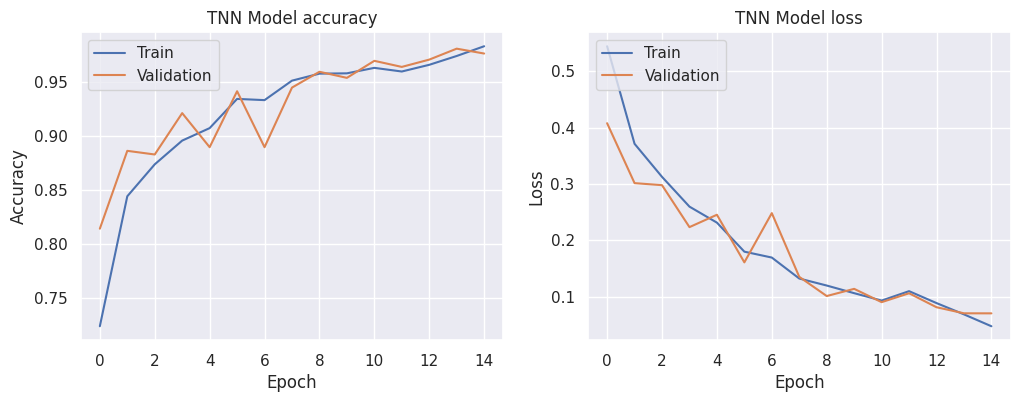

In [ ]:

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('TNN Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')


    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('TNN Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.show()

plot_training_history(TNN_final_history )

**RNN-Hyperparameter tuning**

In [83]:
import keras_tuner as kt

def RNN_GS_model(hp):
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1)
    learning_rate = hp.Choice('learning_rate', values=[1e-4, 1e-3, 1e-2])
    clipvalue = hp.Choice('clipvalue', values=[0.5, 1.0])

    model = Sequential()
    model.add(SimpleRNN(50, input_shape=(X_train_RNN.shape[1], X_train_RNN.shape[2]), return_sequences=True))
    model.add(Dropout(dropout_rate))
    model.add(SimpleRNN(50))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate, clipvalue=clipvalue)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model


tuner = kt.Hyperband(
    RNN_GS_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='my_dir',
    project_name='rnn_hyperparam_tuning'
)


X_train_RNN_GS, X_test_RNN_GS, y_train_RNN_GS, y_test_RNN_GS = train_test_split(X_train_RNN, y_train_RNN, test_size=0.20, random_state=19)

tuner.search(X_train_RNN_GS, y_train_RNN_GS, epochs=10, validation_data=(X_test_RNN_GS, y_test_RNN_GS), verbose=1)
RNN_best_model = tuner.get_best_models(num_models=1)[0]
RNN_best_hp = tuner.get_best_hyperparameters()[0]

print(f"Best Hyperparameters: {RNN_best_hp.values}")


RNN_HT_history = RNN_best_model.fit(X_train_RNN_GS, y_train_RNN_GS, epochs=10, batch_size=16, validation_split=0.2)

RNN_HT_test_loss, RNN_HT_test_accuracy = RNN_best_model.evaluate(X_test_RNN_GS, y_test_RNN_GS)
print(f"Test Loss: {RNN_HT_test_loss}")
print(f"Test Accuracy: {RNN_HT_test_accuracy}")




Trial 23 Complete [00h 02m 27s]
val_accuracy: 0.48703494668006897

Best val_accuracy So Far: 0.572717010974884
Total elapsed time: 00h 41m 09s


NameError: name 'best_hp' is not defined

In [84]:
print(f"Best Hyperparameters: {RNN_best_hp.values}")


RNN_HT_history = RNN_best_model.fit(X_train_RNN_GS, y_train_RNN_GS, epochs=10, batch_size=16, validation_split=0.2)

RNN_HT_test_loss, RNN_HT_test_accuracy = RNN_best_model.evaluate(X_test_RNN_GS, y_test_RNN_GS)
print(f"Test Loss: {RNN_HT_test_loss}")
print(f"Test Accuracy: {RNN_HT_test_accuracy}")



Best Hyperparameters: {'dropout_rate': 0.30000000000000004, 'learning_rate': 0.01, 'clipvalue': 1.0, 'tuner/epochs': 4, 'tuner/initial_epoch': 2, 'tuner/bracket': 2, 'tuner/round': 1, 'tuner/trial_id': '0006'}
Epoch 1/10
178/178 [==============================] - 80s 382ms/step - loss: 0.7116 - accuracy: 0.5046 - val_loss: 0.6827 - val_accuracy: 0.5684
Epoch 2/10
178/178 [==============================] - 47s 263ms/step - loss: 0.7060 - accuracy: 0.5205 - val_loss: 0.7097 - val_accuracy: 0.5205
Epoch 3/10
178/178 [==============================] - 46s 260ms/step - loss: 0.7081 - accuracy: 0.5226 - val_loss: 0.6861 - val_accuracy: 0.5670
Epoch 4/10
178/178 [==============================] - 48s 268ms/step - loss: 0.7099 - accuracy: 0.5212 - val_loss: 0.6885 - val_accuracy: 0.5487
Epoch 5/10
178/178 [==============================] - 46s 259ms/step - loss: 0.7054 - accuracy: 0.5190 - val_loss: 0.6967 - val_accuracy: 0.5247
Epoch 6/10
178/178 [==============================] - 48s 268ms/s

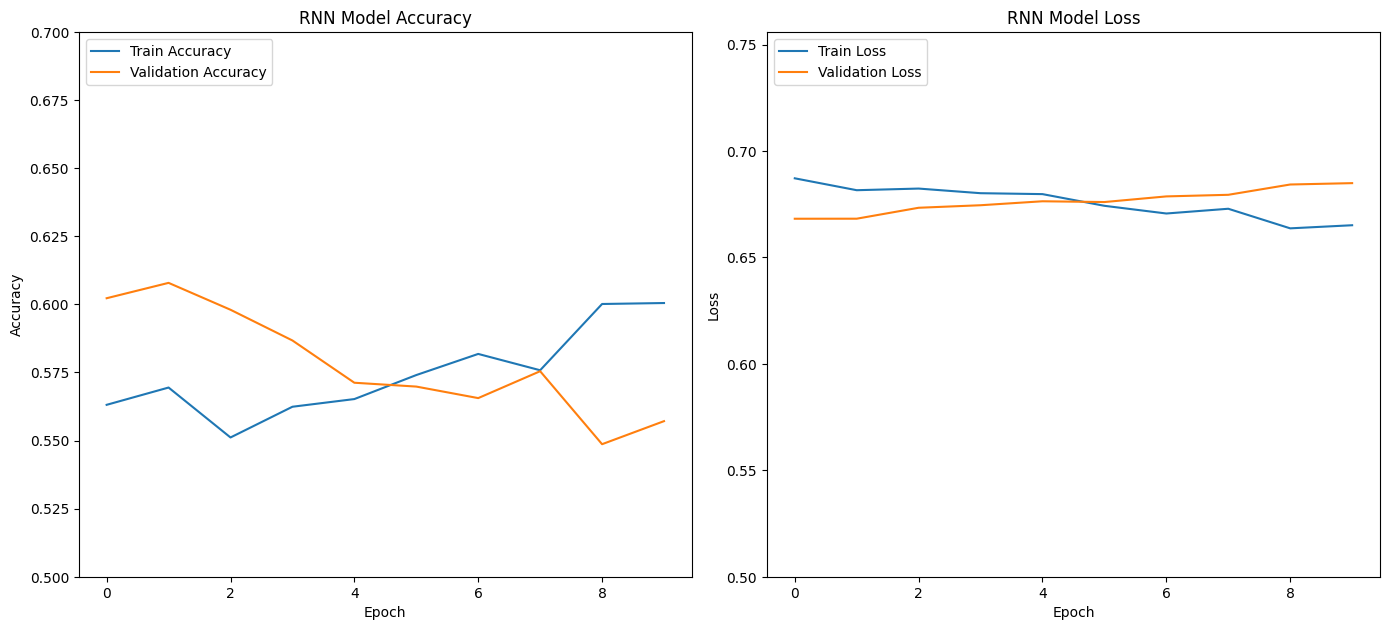

In [ ]:

def plot_training_history(RNN_HT_history):
    plt.figure(figsize=(14, 12))


    plt.subplot(2, 2, 1)
    plt.plot(RNN_HT_history.history['accuracy'], label='Train Accuracy')
    plt.plot(RNN_HT_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('RNN Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.ylim([0.5, 0.7])


    plt.subplot(2, 2, 2)
    plt.plot(RNN_HT_history.history['loss'], label='Train Loss')
    plt.plot(RNN_HT_history.history['val_loss'], label='Validation Loss')
    plt.title('RNN Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.ylim([0.5, max(RNN_HT_history.history['loss'] + RNN_HT_history.history['val_loss']) * 1.1])

    plt.tight_layout()
    plt.show()

plot_training_history(RNN_HT_history)



35/35 [==============================] - 2s 55ms/step


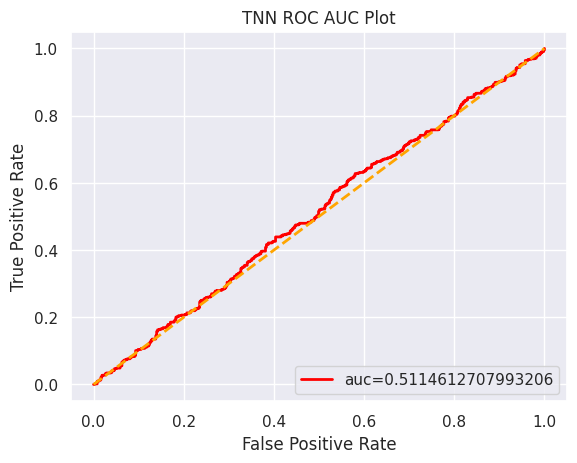

In [85]:
RNN_HT_y_pred = RNN_best_model.predict(X_test_NN)
RNN_HT_fpr, RNN_HT_tpr, _ = roc_curve(y_test_NN,  RNN_HT_y_pred)
RNN_HT_auc = roc_auc_score(y_test_NN, RNN_HT_y_pred)
plt.plot(RNN_HT_fpr,RNN_HT_tpr,label="auc="+str(RNN_HT_auc),color='red',lw=2)
plt.plot([0, 1], [0, 1], color="orange", lw=2, linestyle="--")
plt.title('TNN ROC AUC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()


**SUMMARY PLOTTING**

<ipython-input-4-60d583b33f50>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)


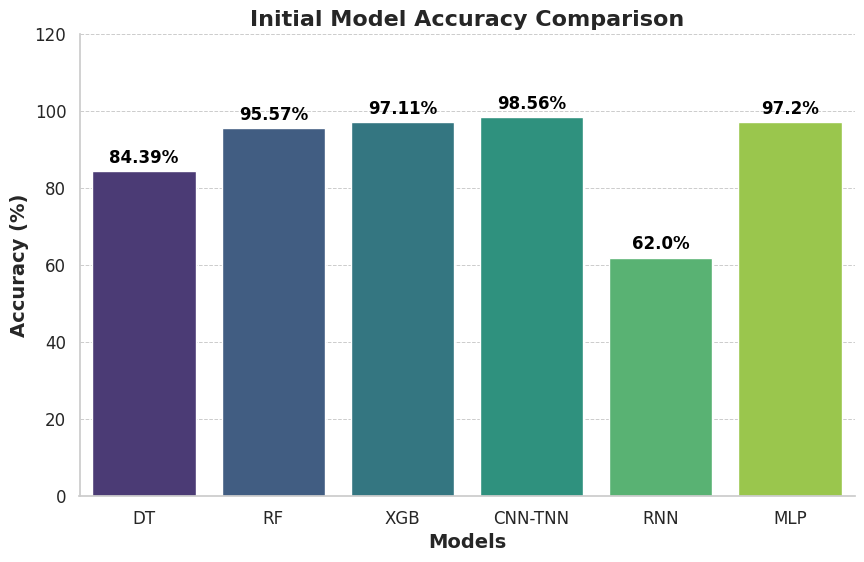

In [ ]:

modelss = ['DT', 'RF', 'XGB', 'CNN-TNN', 'RNN', 'MLP']
accuracy_initial = [84.39, 95.57, 97.11, 98.56, 62.00, 97.20]


sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(modelss))


plt.figure(figsize=(10, 6))
bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)

for bar, acc in zip(bars.patches, accuracy_initial):
    plt.annotate(f'{acc}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black')

plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Initial Model Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylim(0, 120)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)
sns.despine()

plt.show()

<ipython-input-73-f0f7f9849afb>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)
<ipython-input-73-f0f7f9849afb>:11: UserWarning: The palette list has more values (6) than needed (4), which may not be intended.
  bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)


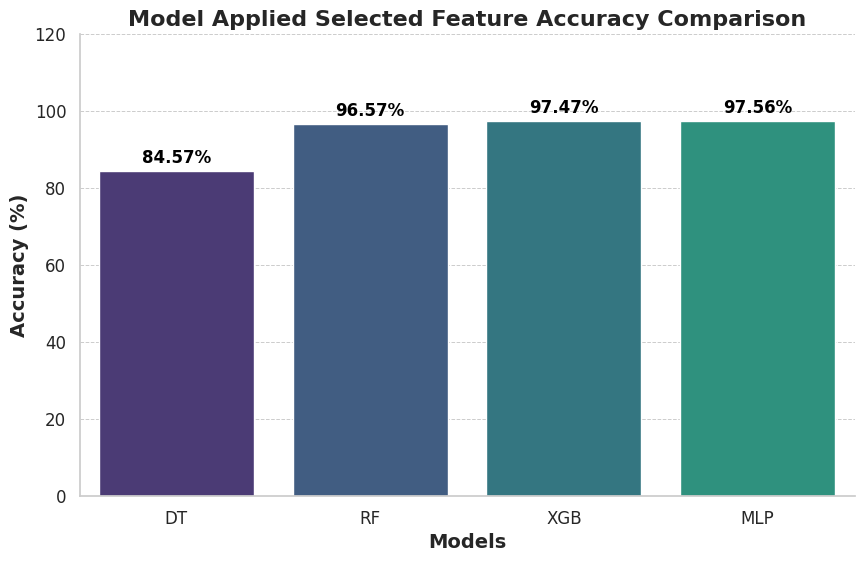

In [ ]:

modelss = ['DT', 'RF', 'XGB', 'MLP']
accuracy_initial = [84.57, 96.57, 97.47, 97.56]

sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(models))

plt.figure(figsize=(10, 6))
bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)

for bar, acc in zip(bars.patches, accuracy_initial):
    plt.annotate(f'{acc}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black')

plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Model Applied Selected Feature Accuracy Comparison', fontsize=16, fontweight='bold')
plt.ylim(0, 120)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)


sns.despine()

plt.show()

<ipython-input-4-9c93f7e06b30>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)


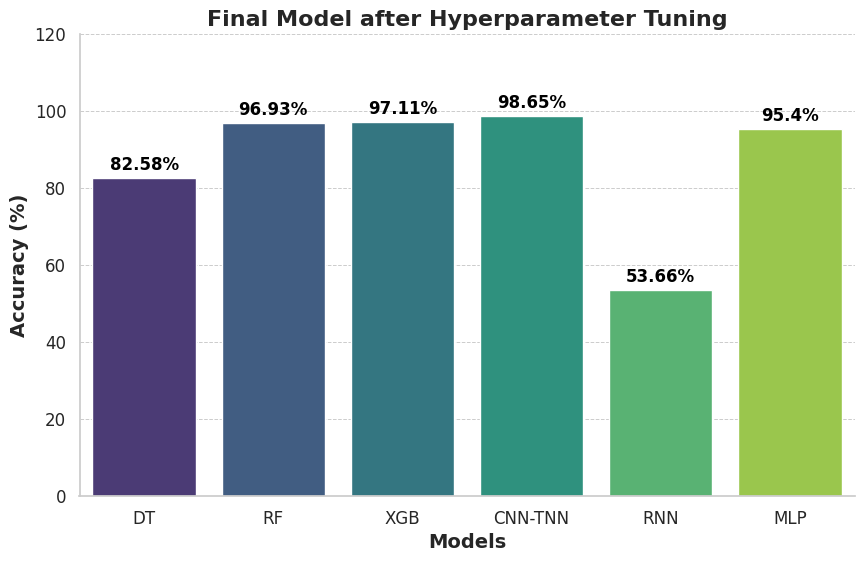

In [ ]:

modelss = ['DT', 'RF', 'XGB', 'CNN-TNN', 'RNN', 'MLP']
accuracy_initial = [82.58, 96.93, 97.11, 98.65, 53.66, 95.40]


sns.set(style="whitegrid")
palette = sns.color_palette("viridis", len(modelss))


plt.figure(figsize=(10, 6))
bars = sns.barplot(x=modelss, y=accuracy_initial, palette=palette)


for bar, acc in zip(bars.patches, accuracy_initial):
    plt.annotate(f'{acc}%',
                 xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom',
                 fontsize=12, fontweight='bold', color='black')

plt.xlabel('Models', fontsize=14, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=14, fontweight='bold')
plt.title('Final Model after Hyperparameter Tuning', fontsize=16, fontweight='bold')
plt.ylim(0, 120)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', linewidth=0.7)

sns.despine()

plt.show()

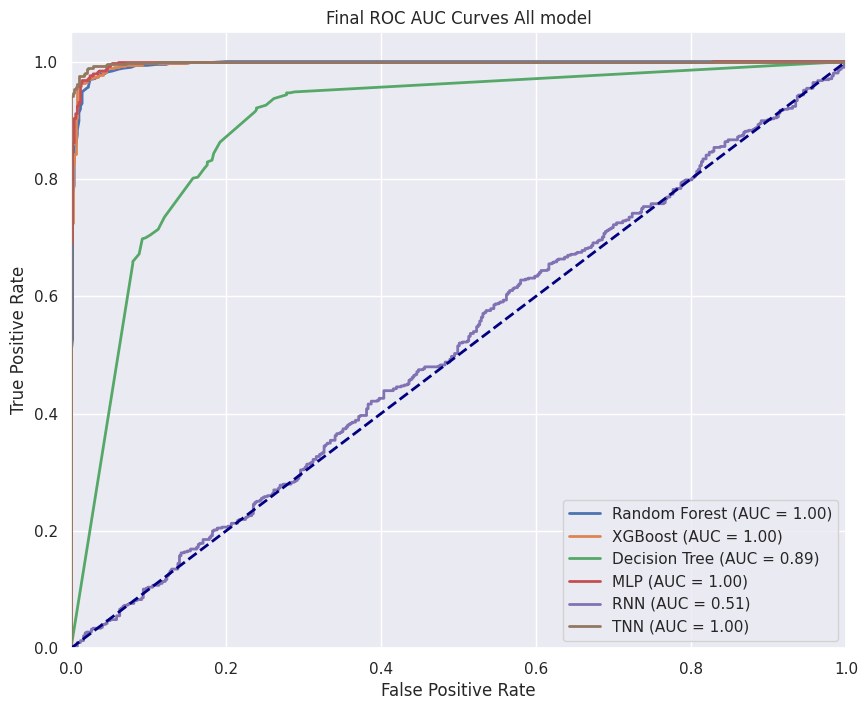

In [87]:
# Create a dictionary to store all ROC AUC information
roc_auc_dict = {
    'Random Forest': {
        'fpr': accuracy_tree['Random Forest_FPR'],
        'tpr': accuracy_tree['Random Forest_TPR'],
        'auc': accuracy_tree['Random Forest_AUC']
    },
    'XGBoost': {
        'fpr': accuracy_tree['XGBoost_FPR'],
        'tpr': accuracy_tree['XGBoost_TPR'],
        'auc': accuracy_tree['XGBoost_AUC']
    },
    'Decision Tree': {
        'fpr': accuracy_tree['Decision Tree_FPR'],
        'tpr': accuracy_tree['Decision Tree_TPR'],
        'auc': accuracy_tree['Decision Tree_AUC']
    },
    'MLP': {
        'fpr': MLP_HT_fpr,
        'tpr': MLP_HT_tpr,
        'auc': MLP_HT_auc
    },
    'RNN': {
        'fpr': RNN_HT_fpr,
        'tpr': RNN_HT_tpr,
        'auc': RNN_HT_auc
    },
    'TNN': {
        'fpr': TNN_HT_fpr,
        'tpr': TNN_HT_tpr,
        'auc': TNN_HT_auc
    }
}

# Now plot the ROC curves for all models
plt.figure(figsize=(10, 8))
for model_name, roc_data in roc_auc_dict.items():
    plt.plot(roc_data['fpr'], roc_data['tpr'], lw=2, label=f'{model_name} (AUC = {roc_data["auc"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Final ROC AUC Curves All model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
